In [1]:
# seurat version
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        

In [2]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

# Basic Seurat

In [3]:
library("Seurat")
# ref https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html

In [5]:
library(dplyr)
library(patchwork)

In [9]:
library(ggplot2)
library(Cairo)

In [21]:
outputRoot=paste0( getwd(), "/backup/a1/")
outputRoot

[1] "/data/wangjl/scScripts/backup/a1/"

In [ ]:
# data feature:
# mt-pct high: 11(naive T), 16()
# HB-pct high: 19(last, Platelet)
# GAPDH low: 11(naive T，部分双峰)
# cell cycle high: 17

# no marker: 14;

## load data

In [6]:
# Load the PBMC dataset
#(1) 10k Peripheral blood mononuclear cells (PBMCs) from a healthy donor, Single Indexed
# Single vs Dual Indexing Demonstration (v3.1 Chemistry)
# Cell Ranger 4.0.0
#filtered_feature_bc_matrix:
# $ wget https://cf.10xgenomics.com/samples/cell-exp/4.0.0/SC3_v3_NextGem_SI_PBMC_10K/SC3_v3_NextGem_SI_PBMC_10K_filtered_feature_bc_matrix.tar.gz
# $ tar zxvf SC3_v3_NextGem_SI_PBMC_10K_filtered_feature_bc_matrix.tar.gz

#(2)
filePath="backup/filtered_feature_bc_matrix/"
pbmc.data <- Read10X(data.dir = filePath)
                     #"../data/pbmc3k/filtered_gene_bc_matrices/hg19/")
#
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc10k", min.cells = 3, min.features = 200)
pbmc

An object of class Seurat 
22860 features across 10884 samples within 1 assay 
Active assay: RNA (22860 features)

## pre-processing

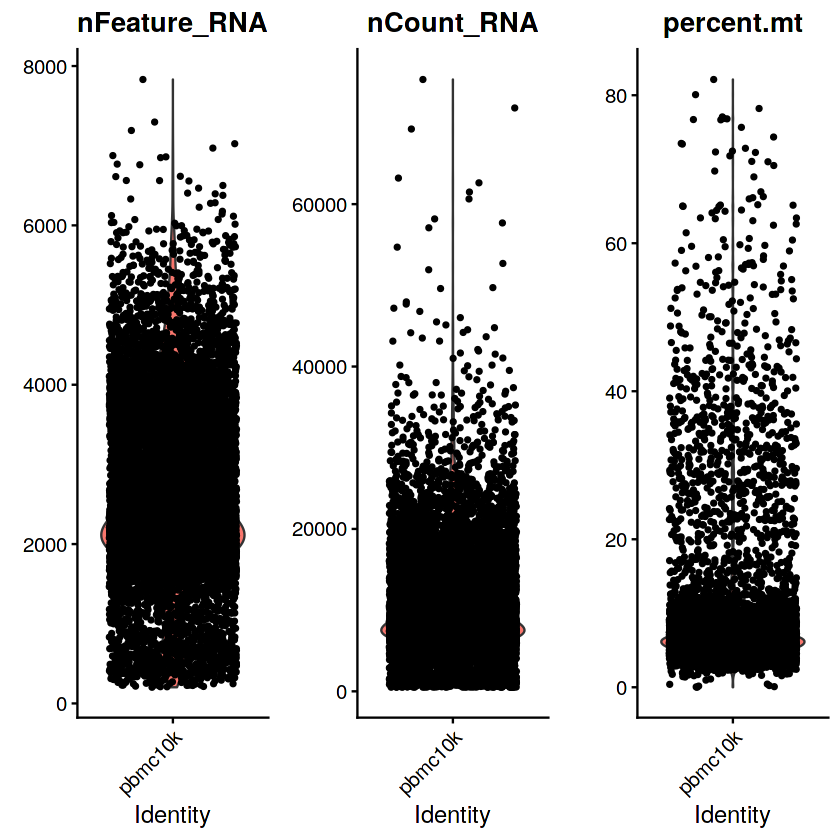

In [7]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [22]:
pdf( paste0(outputRoot, "01_VlnPlot_nFeature_nCount_RNA.pdf"), width=20, height=8)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
dev.off()

png 
  2

#### QC: define a meta-data percent.HB

In [136]:
#计算红细胞比例
scRNA=pbmc
HB.genes <- c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
HB_m <- match(HB.genes, rownames(scRNA@assays$RNA)) 
HB.genes <- rownames(scRNA@assays$RNA)[HB_m]
HB.genes <- HB.genes[!is.na(HB.genes)]
#
scRNA[["percent.HB"]]<-PercentageFeatureSet(scRNA, features=HB.genes) 
head(scRNA@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters percent.HB
AAACCCAGTATCGTAC 0               0         
AAACCCAGTCGGTGAA 13              0         
AAACCCAGTTAGAAAC 0               0         
AAACCCAGTTATCTTC 7               0         
AAACCCAGTTGCCGAC 0               0         
AAACCCAGTTTCCCAC 9               0

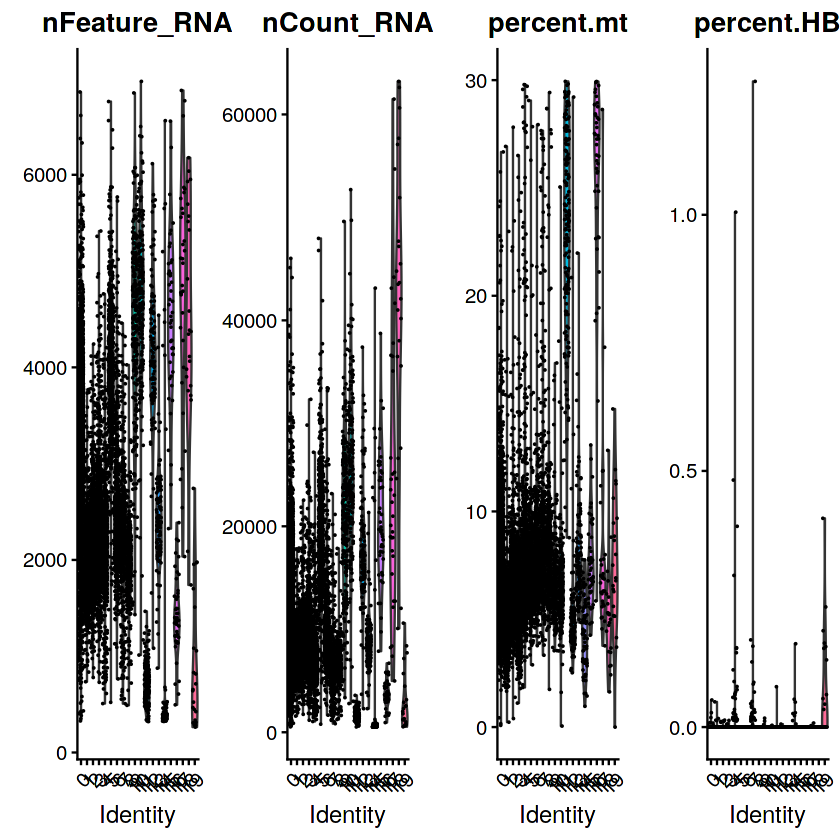

In [141]:
# 分完类，回来再做一次质控。可以整体去掉某一个cluster，然后重新聚类。
violin=VlnPlot(scRNA,
        features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.HB"), 
        #cols =rainbow(20), 
        pt.size = 0.01, #不需要显示点，可以设置pt.size = 0
        ncol = 4) + 
        theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 
violin

In [144]:
ggsave( paste0(outputRoot, "QC_vlnplot_before_qc.pdf"), plot = violin, width = 20, height = 6) 

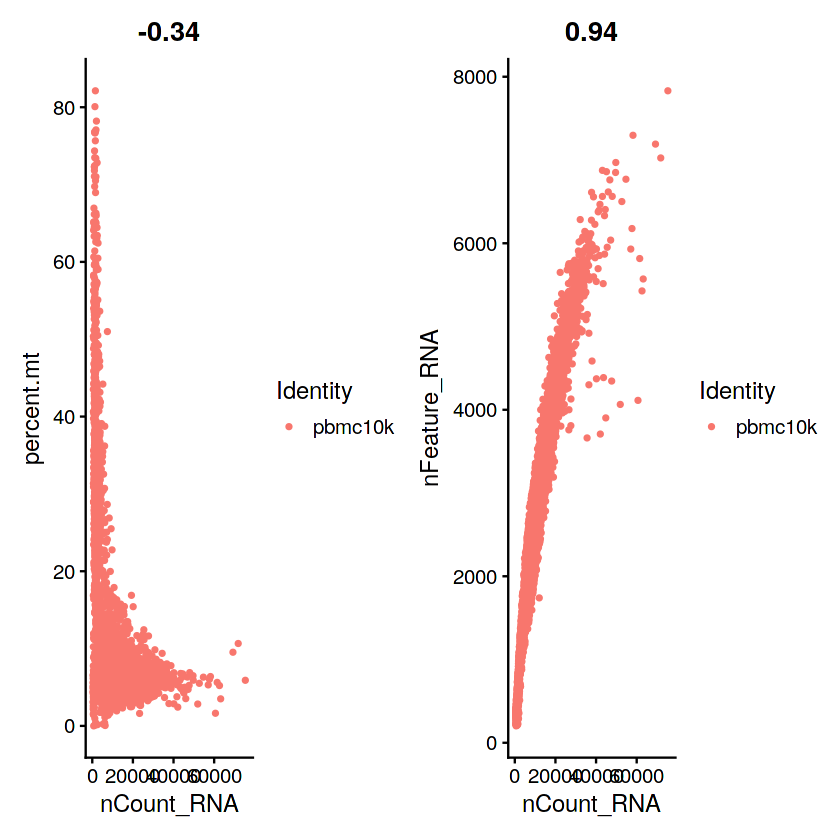

In [12]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [23]:
pdf(paste0(outputRoot, "02_plot_FeatureScatter.pdf"), width=10, height=5)
plot1 + plot2
dev.off()

png 
  2

### filter by MT

In [15]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 7000 & percent.mt < 30)
pbmc

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)

### Normalizing the data

In [17]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

### HVG (feature selection)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results



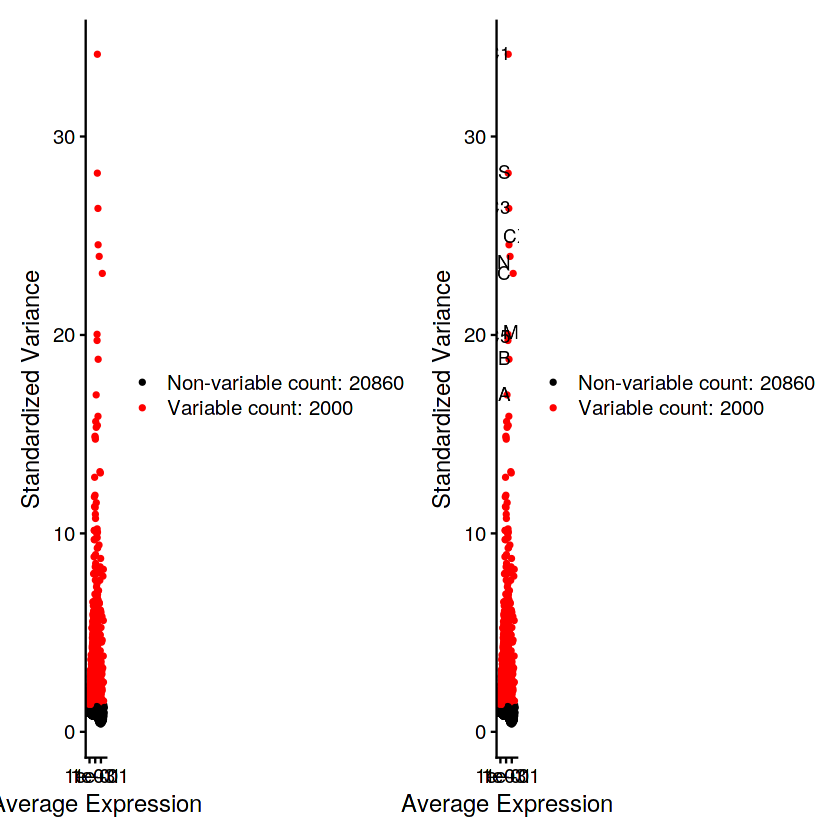

In [18]:
# Identification of highly variable features
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [24]:
pdf( paste0(outputRoot, "03_plot_HVG.pdf"), width=12, height=4)
plot1 + plot2
dev.off()

png 
  2

### Scaling the data 数据中心化

In [25]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



### 获取数据

In [252]:
# Seurat对象中原始表达矩阵经过标准化和中心化之后，已经产生了三套基因表达数据，可以通过以下命令获得

#原始表达矩阵
#GetAssayData(pbmc,slot="counts",assay="RNA") 

#标准化之后的表达矩阵              
#GetAssayData(pbmc,slot="data",assay="RNA")

#中心化之后的表达矩阵 
#GetAssayData(pbmc,slot="scale.data",assay="RNA") 

# test
(function(){
    rs=GetAssayData(pbmc,slot="scale.data",assay="RNA")
    print(dim(rs)) #22860 10441
    rs[1:10,1:3]
})()


[1] 22860 10441


AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC
AL627309.1 -0.06559234      -0.06559234      -0.06559234     
AL627309.3 -0.01647005      -0.01647005      -0.01647005     
AL627309.5 -0.22950478      -0.22950478      -0.22950478     
AL627309.4 -0.02450286      -0.02450286      -0.02450286     
AL669831.2 -0.02321804      -0.02321804      -0.02321804     
LINC01409  -0.26634829      -0.26634829       1.88271209     
FAM87B     -0.04602793      -0.04602793      -0.04602793     
LINC01128  -0.26815450      -0.26815450      -0.26815450     
LINC00115  -0.15798569      -0.15798569      -0.15798569     
FAM41C     -0.17757667      -0.17757667      -0.17757667

## 细胞周期分析(可选)

In [253]:
#上一步找到的高变基因，常常会包含一些细胞周期相关基因。它们会导致细胞聚类发生一定的偏移，
#  即相同类型的细胞在聚类时会因为细胞周期的不同而分开。
#如在Spatially and functionally distinct subclasses of breast cancer-associated fibroblasts revealed 
#  by single cell RNA sequencing 中 vCAFs和cCAFs中只有cell cycle genes的表达差异。

## 内置的细胞周期基因。
cc.genes

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

In [254]:
# 查看我们选择的高变基因中有哪些细胞周期相关基因：
CaseMatch(c(cc.genes$s.genes,cc.genes$g2m.genes),VariableFeatures(pbmc))

MCM5       PCNA       TYMS       FEN1       MCM2       MCM4      GINS2 
    "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    "GINS2" 
      MCM6      CDCA7        DTL      UHRF1      HELLS   RAD51AP1       GMNN 
    "MCM6"    "CDCA7"      "DTL"    "UHRF1"    "HELLS" "RAD51AP1"     "GMNN" 
     ATAD2      RAD51       RRM2      CDC45       CDC6      DSCC1      CLSPN 
   "ATAD2"    "RAD51"     "RRM2"    "CDC45"     "CDC6"    "DSCC1"    "CLSPN" 
      E2F8      HMGB2       CDK1     NUSAP1      UBE2C      BIRC5       TPX2 
    "E2F8"    "HMGB2"     "CDK1"   "NUSAP1"    "UBE2C"    "BIRC5"     "TPX2" 
     TOP2A      NDC80       CKS2       NUF2      CKS1B      MKI67      CENPF 
   "TOP2A"    "NDC80"     "CKS2"     "NUF2"    "CKS1B"    "MKI67"    "CENPF" 
      SMC4      CCNB2     CKAP2L      AURKB       BUB1      KIF11     TUBB4B 
    "SMC4"    "CCNB2"   "CKAP2L"    "AURKB"     "BUB1"    "KIF11"   "TUBB4B" 
     GTSE1     KIF20B      HJURP      CDCA3      CDC20        TTK     CDC25C 
   "GTSE1"   "KIF20B"    "HJURP"    "CDCA3"    "CDC20"      "TTK"   "CDC25C" 
     KIF2C     DLGAP5      CDCA2      CDCA8       ECT2      KIF23       HMMR 
   "KIF2C"   "DLGAP5"    "CDCA2"    "CDCA8"     "ECT2"    "KIF23"     "HMMR" 
     AURKA       ANLN      CENPE       NEK2      CENPA 
   "AURKA"     "ANLN"    "CENPE"     "NEK2"    "CENPA"

### 细胞周期评分

In [255]:
g2m_genes = cc.genes$g2m.genes
g2m_genes = CaseMatch(search = g2m_genes, match = rownames(pbmc))

s_genes = cc.genes$s.genes
s_genes = CaseMatch(search = s_genes, match = rownames(pbmc))

scRNA <- CellCycleScoring(object=pbmc,  g2m.features=g2m_genes,  s.features=s_genes)
scRNA

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [256]:
# 在scRNA@meta.data中添加S.Score、G2M.Score和Phase三列有关细胞周期的信息。
head(scRNA@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters S.Score      G2M.Score   Phase
AAACCCAGTATCGTAC 0               -0.031350430 -0.06614292 G1   
AAACCCAGTCGGTGAA 13               0.002959552 -0.02998830 S    
AAACCCAGTTAGAAAC 0               -0.024807542 -0.05018607 G1   
AAACCCAGTTATCTTC 7               -0.088207475 -0.01127008 G1   
AAACCCAGTTGCCGAC 0               -0.036308037  0.01443284 G2M  
AAACCCAGTTTCCCAC 9               -0.010167652 -0.04613281 G1

In [257]:
table(scRNA@meta.data$Phase)


  G1  G2M    S 
5056 1406 3979 

     
         0    1    2    3    4    5    6    7    8    9   10   11   12   13
  G1  2036  476  471  375  267  437  154  171  135  147  145   71   53   34
  G2M  258  192  190  249  138   20   81   48   56   22    5   43   20   17
  S    513  654  591  618  339  197  307  218  198   63   38   56   40   58
     
        14   15   16   17   18   19
  G1     2   24   31    0   17   10
  G2M   38    3    3   13    1    9
  S     33   19    9   19    5    4


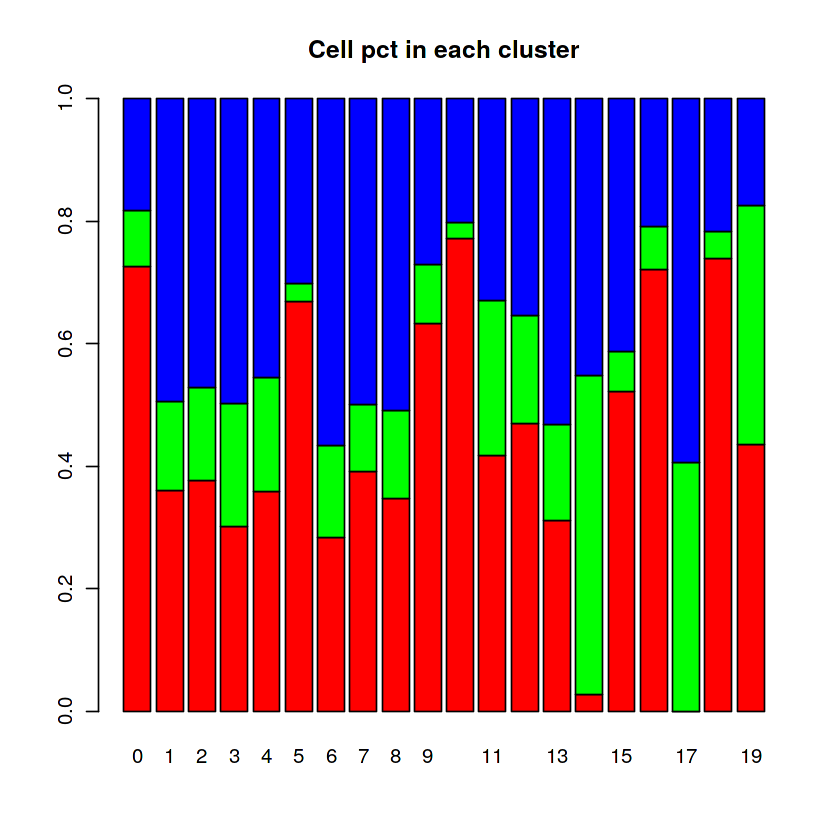

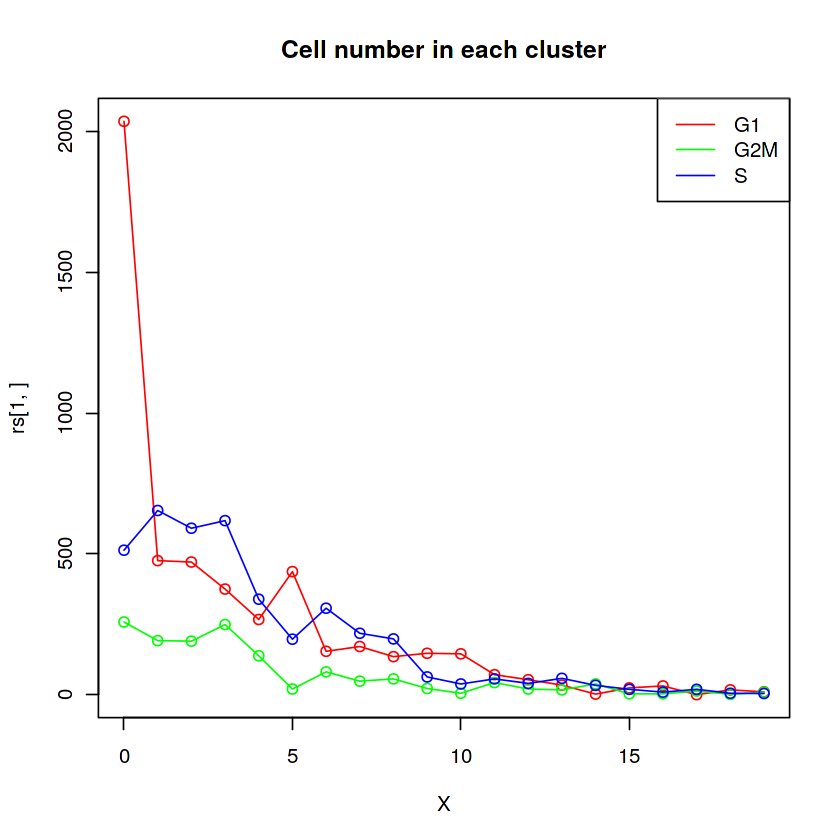

In [278]:
(function(){
    rs=table(scRNA@meta.data$Phase, scRNA@meta.data$seurat_clusters)
    print(rs)
    
    rs2=apply(rs, 2, function(x){x/sum(x)})
    barplot(rs2, col = c("red","green", "blue"), main="Cell pct in each cluster")
    
    X=seq(0,19,1)
    plot(X,rs[1,], col="red", main="Cell number in each cluster", type="o")
    lines(X,rs[2,], col="green", type="o")
    lines(X,rs[3,], col="blue", type="o")
    legend("topright", legend=c("G1", "G2M", "S"), col=c("red","green", "blue"), lty=1 )
})()

### 查看细胞周期基因对细胞聚类的影响

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TYMS, MKI67, NUSAP1, CLSPN, RRM2, TOP2A, BIRC5, TPX2, GTSE1, CENPF 
	   UBE2C, CDK1, UHRF1, CKAP2L, AURKB, CENPE, DLGAP5, CDC45, KIF11, HMMR 
	   DSCC1, CCNB2, RAD51, CENPA, FEN1, NDC80, NUF2, HJURP, PCNA, CDCA8 
Negative:  RANGAP1, GAS2L3, CASP8AP2, PSRC1, G2E3, MSH2, POLD3, RPA2, TIPIN, CTCF 
	   UNG, POLA1, PRIM1, UBR7, LBR, RFC2, BLM, CKAP5, CBX5, TACC3 
	   CHAF1B, TMPO, NCAPD2, USP1, ANP32E, CDC25C, SLBP, BRIP1, NASP, ECT2 
PC_ 2 
Positive:  HMGB2, KIF23, AURKA, TACC3, PSRC1, CENPE, CENPF, AURKB, KIF2C, DLGAP5 
	   ECT2, CCNB2, CDC20, CENPA, BUB1, POLD3, HMMR, TPX2, CKAP5, TOP2A 
	   NEK2, BIRC5, NUF2, NUSAP1, CDCA8, KIF11, NCAPD2, CDCA2, LBR, SMC4 
Negative:  RPA2, MCM2, UNG, HELLS, MCM5, WDR76, MCM4, GINS2, MCM6, PCNA 
	   PRIM1, MSH2, NASP, CBX5, FEN1, CASP8AP2, TIPIN, ATAD2, CDC6, CHAF1B 
	   ANP32E, GMN

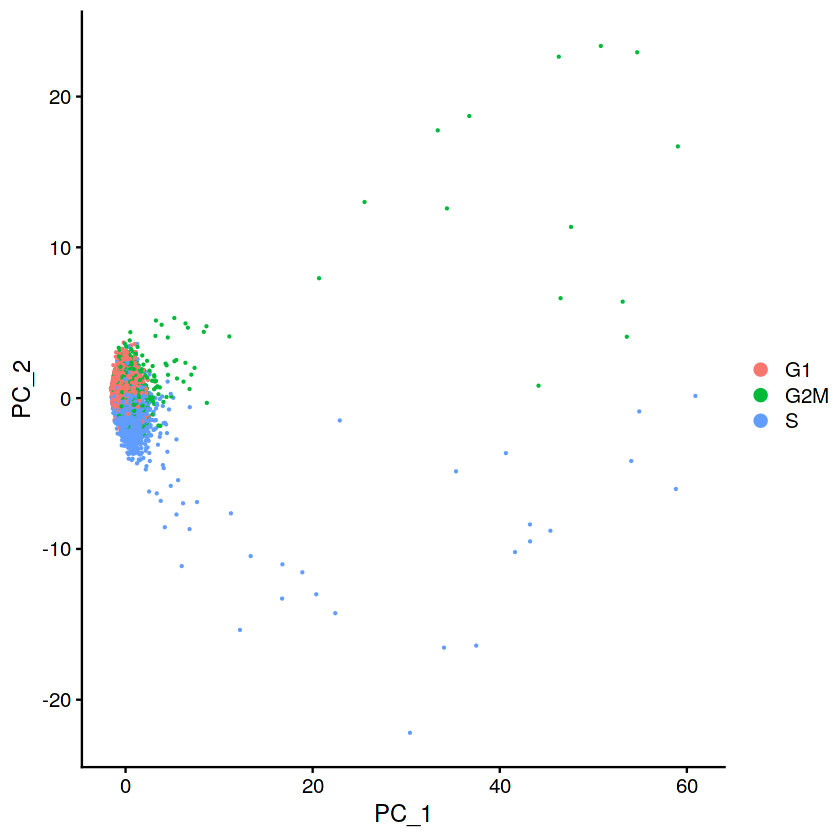

In [279]:
scRNAa <- RunPCA(scRNA, features = c(s_genes, g2m_genes))
DimPlot(scRNAa, reduction = "pca", group.by = "Phase")
#ggsave("cluster/cellcycle_pca.png", p, width = 8, height = 6)

In [ ]:
# 按seurat细胞周期回归分析教程的案例，如果使用周期基因能把细胞分群，提示这种情况需要剔除细胞周期对聚类的影响。
# 我们的图说明还是有影响的，看情况没必要做细胞周期回归分析。

### 消除细胞周期的影响

In [283]:
##如果需要消除细胞周期的影响
if(0){
 scRNAb <- ScaleData(scRNAa, vars.to.regress = c("S.Score", "G2M.Score"), features = rownames(scRNA)) #比较慢，19:39-19:51 还没结束，暂停掉了
}

Regressing out S.Score, G2M.Score



In [284]:
if(0){
 scRNAb <- RunPCA(scRNAb, features = c(s_genes, g2m_genes))
 DimPlot(scRNAb, reduction = "pca", group.by = "Phase")
}

ERROR: Error in RunPCA(scRNAb, features = c(s_genes, g2m_genes)): object 'scRNAb' not found


## PCA 

In [33]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc),  
               nfeatures.print = 5, # default 30
               npcs = 100) # default 50
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  IL32, LTB, TRAC, CD3D, TRBC2 
Negative:  FGL2, FCN1, IFI30, CST3, MNDA 
PC_ 2 
Positive:  IL32, CD3D, CD3G, CD7, TRAC 
Negative:  BCL11A, NIBAN3, IGHM, CD79A, BANK1 
PC_ 3 
Positive:  CCR7, MS4A1, CD79A, LINC00926, LTB 
Negative:  GZMB, CLIC3, NKG7, C12orf75, GNLY 
PC_ 4 
Positive:  GNLY, NKG7, KLRD1, PRF1, CST7 
Negative:  LILRA4, CLEC4C, SERPINF1, SCT, TPM2 
PC_ 5 
Positive:  S100A12, ITGAM, VCAN, CES1, PADI4 
Negative:  CDKN1C, HES4, CTSL, BATF3, TCF7L2 



PC_ 1 
Positive:  IL32, LTB, TRAC, CD3D, TRBC2 
Negative:  FGL2, FCN1, IFI30, CST3, MNDA 
PC_ 2 
Positive:  IL32, CD3D, CD3G, CD7, TRAC 
Negative:  BCL11A, NIBAN3, IGHM, CD79A, BANK1 
PC_ 3 
Positive:  CCR7, MS4A1, CD79A, LINC00926, LTB 
Negative:  GZMB, CLIC3, NKG7, C12orf75, GNLY 
PC_ 4 
Positive:  GNLY, NKG7, KLRD1, PRF1, CST7 
Negative:  LILRA4, CLEC4C, SERPINF1, SCT, TPM2 
PC_ 5 
Positive:  S100A12, ITGAM, VCAN, CES1, PADI4 
Negative:  CDKN1C, HES4, CTSL, BATF3, TCF7L2 


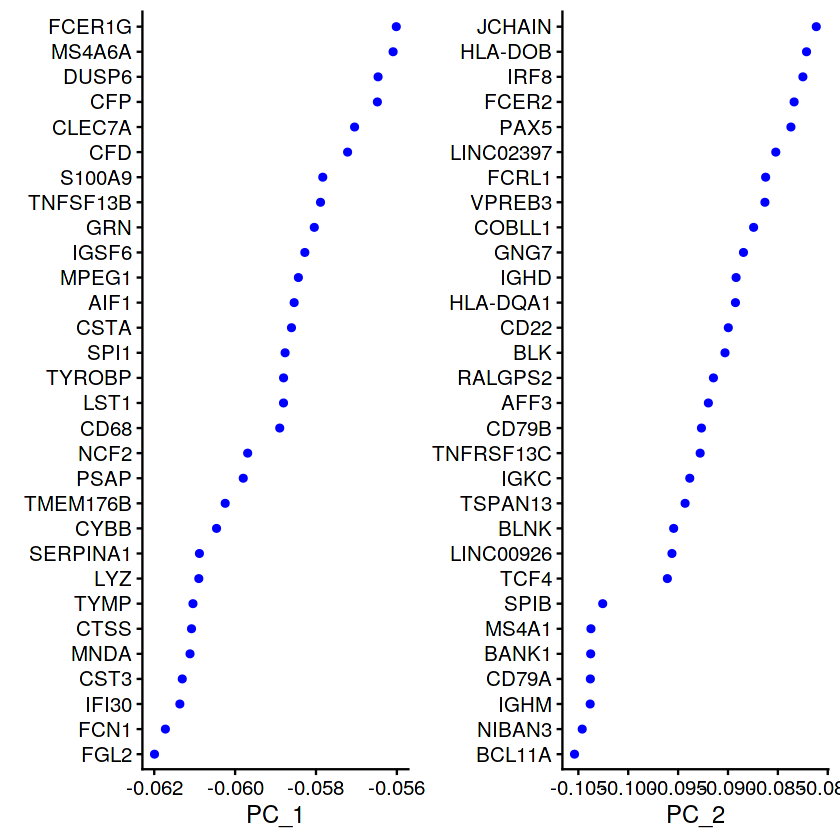

In [34]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

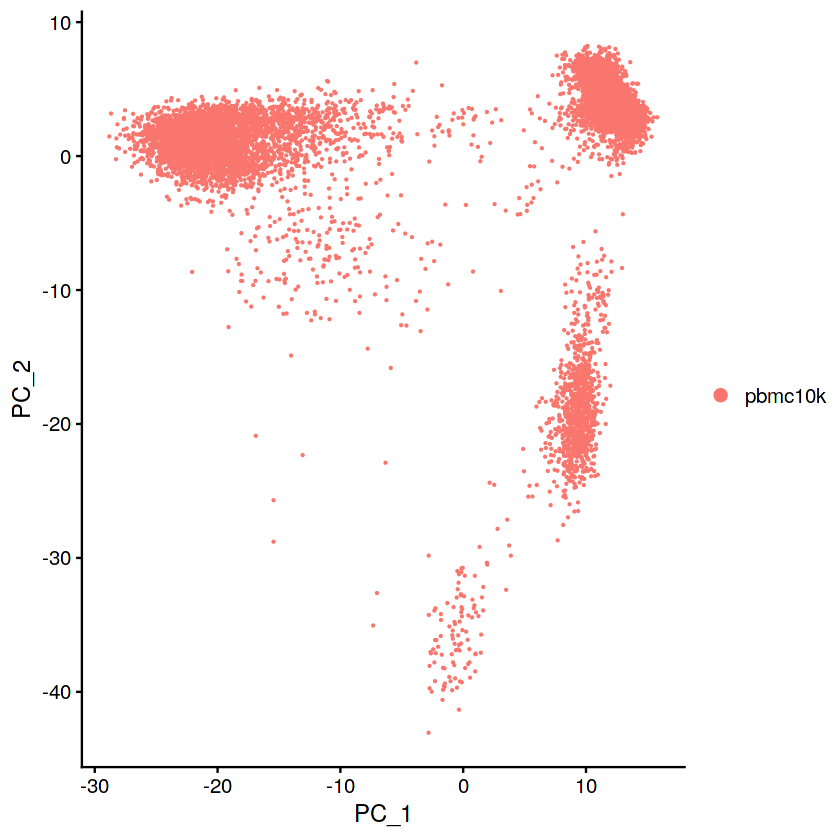

In [35]:
DimPlot(pbmc, reduction = "pca")

In [36]:
pdf( paste0(outputRoot, "04_plot_PCA.pdf"), width=5, height=4.5)
DimPlot(pbmc, reduction = "pca")
DimPlot(pbmc, reduction = "pca", dims = c(1, 3))
DimPlot(pbmc, reduction = "pca", dims = c(2, 3))
dev.off()

png 
  2

### （可选）获取PC的loadings

In [286]:
#获取基因在pc轴上的投射值
head( Loadings(object = pbmc[["pca"]]) )

PC_1         PC_2          PC_3         PC_4        PC_5       
IGLC1   0.005065306 -0.0475797453  0.018601588  0.03132590  0.01370402
PTGDS   0.002697881 -0.0166562026 -0.061439764 -0.01660988  0.01383248
IGLC3   0.005802392 -0.0566921442  0.015893315  0.02949543  0.01451554
CXCL10 -0.020154831 -0.0002904893 -0.003920062  0.01501876 -0.05878288
JCHAIN  0.004883524 -0.0811485587 -0.040923327 -0.03573705  0.01206621
IGKC    0.008081816 -0.0938307194  0.015474176  0.03564225  0.02357601
       PC_6         PC_7         PC_8        PC_9         PC_10       ⋯
IGLC1  -0.008971311 -0.001768012 0.009382149 -0.001612488  0.00682897 ⋯
PTGDS   0.021263078 -0.020250745 0.014794631  0.016647598 -0.00147420 ⋯
IGLC3   0.002409566  0.001428248 0.008002063 -0.007225337  0.00994742 ⋯
CXCL10  0.007677880  0.046535941 0.022752979  0.064577209  0.04899423 ⋯
JCHAIN -0.007254635 -0.004209644 0.029575267 -0.017381708  0.03274579 ⋯
IGKC   -0.007064725 -0.003612554 0.015803654 -0.008921159  0.02278750 ⋯
       PC_91        PC_92        PC_93        PC_94        PC_95        
IGLC1   0.025719209  0.028857738  0.037971709  0.041473333 -0.0080458806
PTGDS   0.065058364  0.004393225  0.042837289 -0.035141671 -0.0018748377
IGLC3   0.024900632  0.001638009 -0.006478119  0.005022253  0.0516523641
CXCL10  0.021613286 -0.012741216  0.042381267 -0.010276082  0.0002669727
JCHAIN -0.008790629  0.016429119 -0.001436845 -0.011251534 -0.0004586329
IGKC   -0.012728873  0.002729198  0.001910613 -0.010227099 -0.0165478843
       PC_96        PC_97         PC_98        PC_99        PC_100      
IGLC1  -0.022415162 -0.0005048252 -0.008720821  0.044696055  0.006836985
PTGDS   0.003692768 -0.0045976291 -0.028120041 -0.003209545 -0.012707251
IGLC3   0.014202180 -0.0423900389  0.030200528 -0.017043284 -0.057811448
CXCL10 -0.011854996  0.0232884871  0.031247070  0.017201303  0.003444946
JCHAIN  0.018192061  0.0036895566 -0.001522755  0.012341830 -0.002215231
IGKC    0.001718388  0.0237539216 -0.024165389 -0.001643838  0.043280655

In [287]:
#获取各个细胞的pc值
head( Embeddings(object = scRNA[["pca"]]) )

PC_1       PC_2     PC_3       PC_4       PC_5       
AAACCCAGTATCGTAC  -6.657777 1.624132   2.376272  1.7028841 -6.05649330
AAACCCAGTCGGTGAA  13.097682 4.800738  -1.535747  1.4142074  0.57204529
AAACCCAGTTAGAAAC -23.527514 1.035331   1.250562 -1.0044033  4.73075650
AAACCCAGTTATCTTC  11.310227 6.385466 -15.967999 13.0666315  6.01642804
AAACCCAGTTGCCGAC -19.264760 1.939729   1.712579 -0.7320984  2.35905505
AAACCCAGTTTCCCAC -13.520543 1.861992   2.077127 -1.4246722  0.01728096
                 PC_6       PC_7       PC_8        PC_9       PC_10      ⋯
AAACCCAGTATCGTAC  1.9155182  1.2232378  1.17968377  4.1321691  3.1442960 ⋯
AAACCCAGTCGGTGAA  0.9267961  3.9040695 -0.01168849 -1.9902429  2.8864436 ⋯
AAACCCAGTTAGAAAC -0.2828093  0.7986938  1.72946786  1.1943742  1.6636139 ⋯
AAACCCAGTTATCTTC  4.7929609 -5.6210477  1.36457800  7.3986573 -4.1222989 ⋯
AAACCCAGTTGCCGAC  0.7794639 -1.0549815  2.27048496  0.4082076  0.3617599 ⋯
AAACCCAGTTTCCCAC  0.6411534  2.1879204  0.62916911  1.1826417  0.6435039 ⋯
                 PC_91      PC_92      PC_93      PC_94       PC_95        
AAACCCAGTATCGTAC  0.2097788 -0.7183071  0.8379345 -1.46010447 -7.541964e-01
AAACCCAGTCGGTGAA -0.6278759 -0.4172395 -0.9925892 -1.25650108 -2.027226e-01
AAACCCAGTTAGAAAC  0.3837419  2.3464723 -0.3770831  0.50303861 -7.700109e-01
AAACCCAGTTATCTTC -0.1901534  2.8620907 -2.5344350  1.30509168  2.308451e+00
AAACCCAGTTGCCGAC -0.9234588  0.4194250  1.1078186 -0.66979205 -2.809800e-01
AAACCCAGTTTCCCAC  1.1296882 -0.6700625 -0.3554427 -0.03055635  7.444160e-07
                 PC_96      PC_97      PC_98       PC_99       PC_100    
AAACCCAGTATCGTAC -0.2896359  0.7095169  3.41069505 -1.44974704 -1.3305880
AAACCCAGTCGGTGAA -1.1481496 -1.5219129 -0.86759555 -1.49057976  0.5783217
AAACCCAGTTAGAAAC  0.8461259  1.2041672  0.79985972 -0.79386328 -0.9743461
AAACCCAGTTATCTTC -1.3665211  1.5998329 -0.73966326 -0.07917744  0.7285470
AAACCCAGTTGCCGAC -0.6067421  4.8860156  1.58084746  0.19056348  0.5830111
AAACCCAGTTTCCCAC -0.3326184 -2.0187575 -0.03540336 -0.62476880 -0.6068466

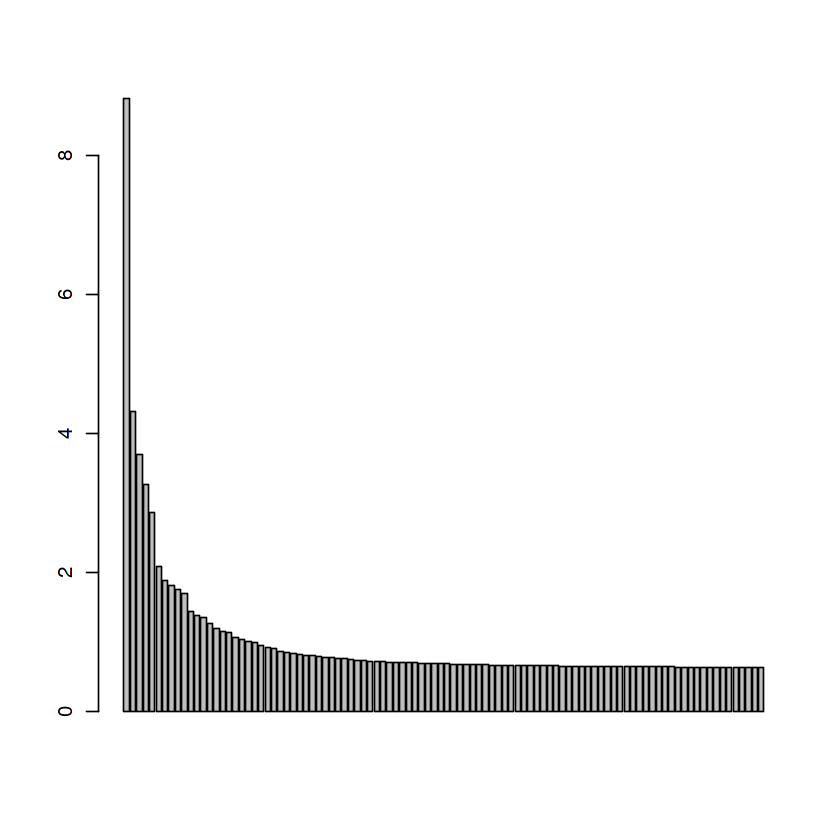

In [291]:
#获取各pc轴解释量方差
(function(){
    rs=Stdev(scRNA)
    barplot( rs/sum(rs)*100  )
})()


In [292]:
#查看决定pc值的top10基因， 此例查看pc1-pc5轴
print(scRNA[["pca"]], dims = 1:5, nfeatures = 10) 

PC_ 1 
Positive:  IL32, LTB, TRAC, CD3D, TRBC2, CD3G, BCL11B, IL7R, ARL4C, CD7 
Negative:  FGL2, FCN1, IFI30, CST3, MNDA, CTSS, TYMP, LYZ, SERPINA1, CYBB 
PC_ 2 
Positive:  IL32, CD3D, CD3G, CD7, TRAC, ANXA1, CD2, GZMM, CD247, BCL11B 
Negative:  BCL11A, NIBAN3, IGHM, CD79A, BANK1, MS4A1, SPIB, TCF4, LINC00926, BLNK 
PC_ 3 
Positive:  CCR7, MS4A1, CD79A, LINC00926, LTB, TNFRSF13C, BANK1, FCRL1, CD22, VPREB3 
Negative:  GZMB, CLIC3, NKG7, C12orf75, GNLY, CST7, PRF1, KLRD1, GZMA, FGFBP2 
PC_ 4 
Positive:  GNLY, NKG7, KLRD1, PRF1, CST7, FCGR3A, CCL4, FGFBP2, KLRF1, HOPX 
Negative:  LILRA4, CLEC4C, SERPINF1, SCT, TPM2, LRRC26, MAP1A, PACSIN1, DNASE1L3, TNFRSF21 
PC_ 5 
Positive:  S100A12, ITGAM, VCAN, CES1, PADI4, QPCT, S100A8, MGST1, CYP1B1, MCEMP1 
Negative:  CDKN1C, HES4, CTSL, BATF3, TCF7L2, CSF1R, SIGLEC10, MS4A7, CASP5, RRAS 


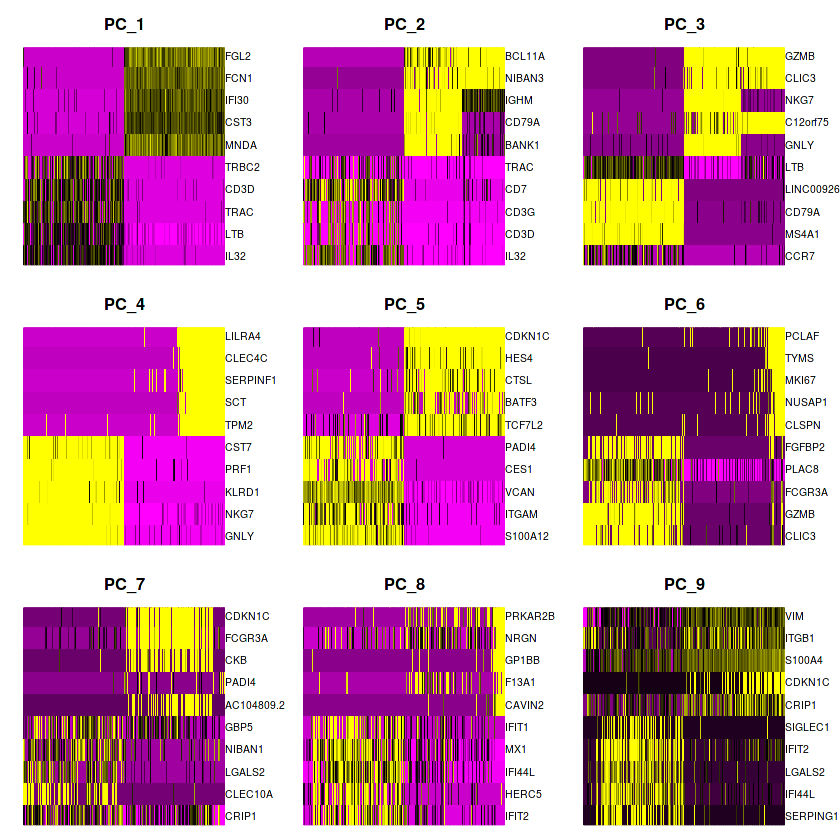

In [294]:
#查看决定pc值的top10基因在500个细胞中的热图，此例查看pc1-pc9轴
DimHeatmap(scRNA, dims = 1:9, nfeatures=10, cells = 500, balanced = TRUE)

### heatmap PC

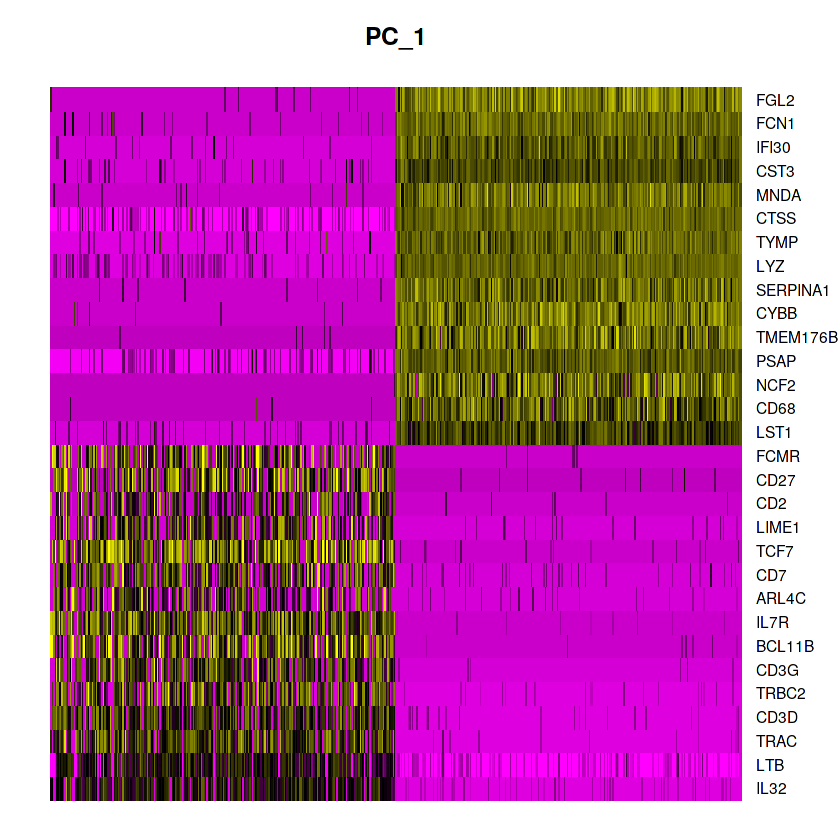

In [30]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

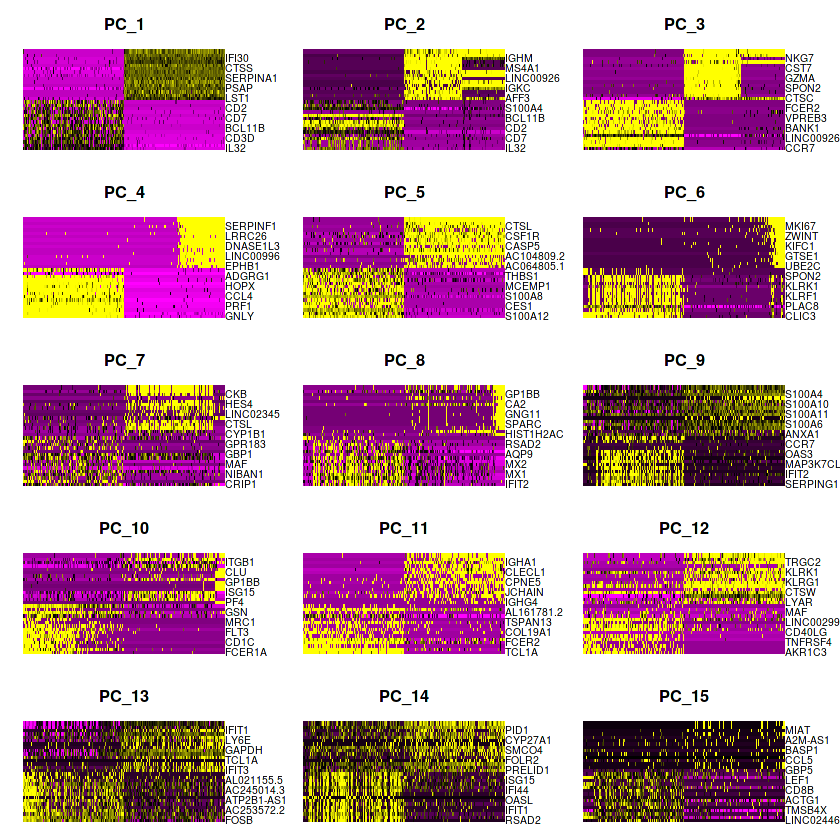

In [31]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

### Determine the 'dimensionality' of the dataset

In [37]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100,
                 dims = 50) # default 20;  耗时 15:30-15:35

In [38]:
pbmc <- ScoreJackStraw(pbmc, dims = 1:50)

Warning message:
“Removed 59543 rows containing missing values (geom_point).”


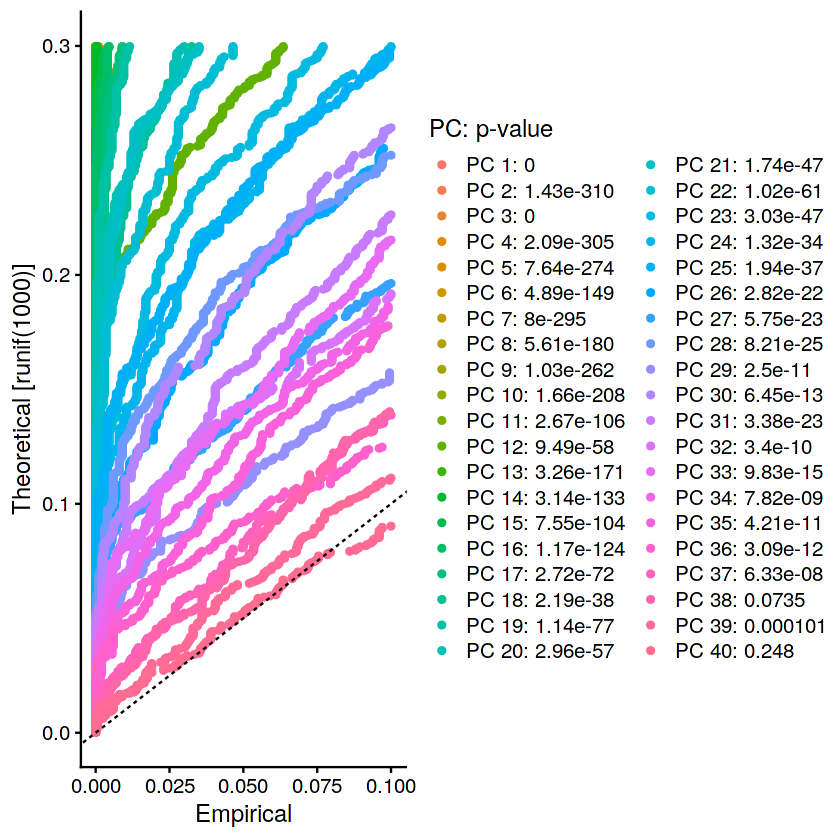

In [42]:
JackStrawPlot(pbmc, dims = 1:40)

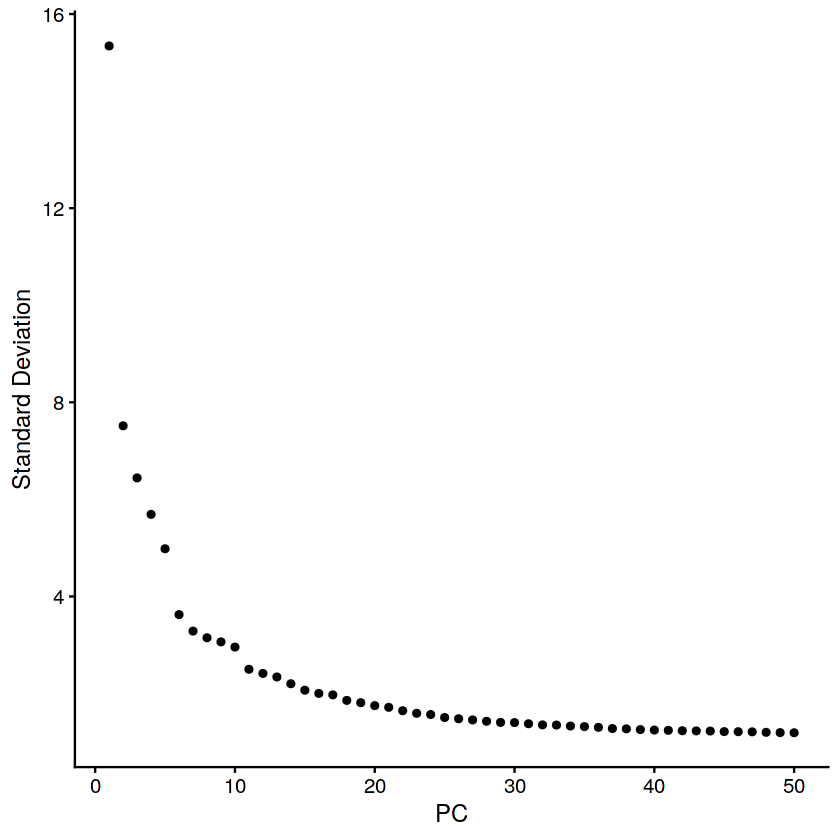

In [44]:
ElbowPlot(pbmc, ndims = 50)

## (关键) Cluster the cells (SNN)

In [121]:
# 关键步骤：这一步是实质细胞分群，给细胞分类标签。后面的tSNE和UMAP只是可视化细胞的位置。

# para: dims, resolution.
pbmc <- FindNeighbors(pbmc, dims = 1:37, # decided by ElbowPlot, JackStrawPlot and DimHeatmap;
                     k.param = 20) # k怎么设置？太大了分类太少。

pbmc <- FindClusters(pbmc, resolution = 0.5) # 0.5分到20 个类; 0.8分到22个类
pbmc
###########
# 分辨率 resolution：
# 需要指定0.1-0.9之间的一个数值，用于决定clusters的相对数量，数值越大cluters越多。

# We find that setting this parameter between 0.6-1.2 typically returns good results for single cell datasets of around 3K cells. 
# 设置更大的resolution，分到更多的类。 大数据集，要设置更大的分辨率。

###########
# algorithm： 
#  Algorithm for modularity optimization (1 = original Louvain algorithm; 
#2 = Louvain algorithm with multilevel refinement; 
#3 = SLM algorithm; 
#4 = Leiden algorithm). Leiden requires the leidenalg python.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10441
Number of edges: 430791

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9198
Number of communities: 20
Elapsed time: 1 seconds


An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [125]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
               0               13                0                7 
AAACCCAGTTGCCGAC 
               0 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [295]:
table(pbmc@meta.data$seurat_clusters) #每个类有多少个细胞


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2807 1322 1252 1242  744  654  542  437  389  232  188  170  113  109   73   46 
  16   17   18   19 
  43   32   23   23 

## Run UMAP

In [126]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages ='umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:37) # time 15:47 - 15:49

16:54:19 UMAP embedding parameters a = 0.9922 b = 1.112

16:54:19 Read 10441 rows and found 37 numeric columns

16:54:19 Using Annoy for neighbor search, n_neighbors = 30

16:54:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:54:20 Writing NN index file to temp file /tmp/RtmpZJSMvl/file1955101f9cc2

16:54:20 Searching Annoy index using 1 thread, search_k = 3000

16:54:23 Annoy recall = 100%

16:54:24 Commencing smooth kNN distance calibration using 1 thread

16:54:24 Initializing from normalized Laplacian + noise

16:54:25 Commencing optimization for 200 epochs, with 456222 positive edges

16:54:29 Optimization finished



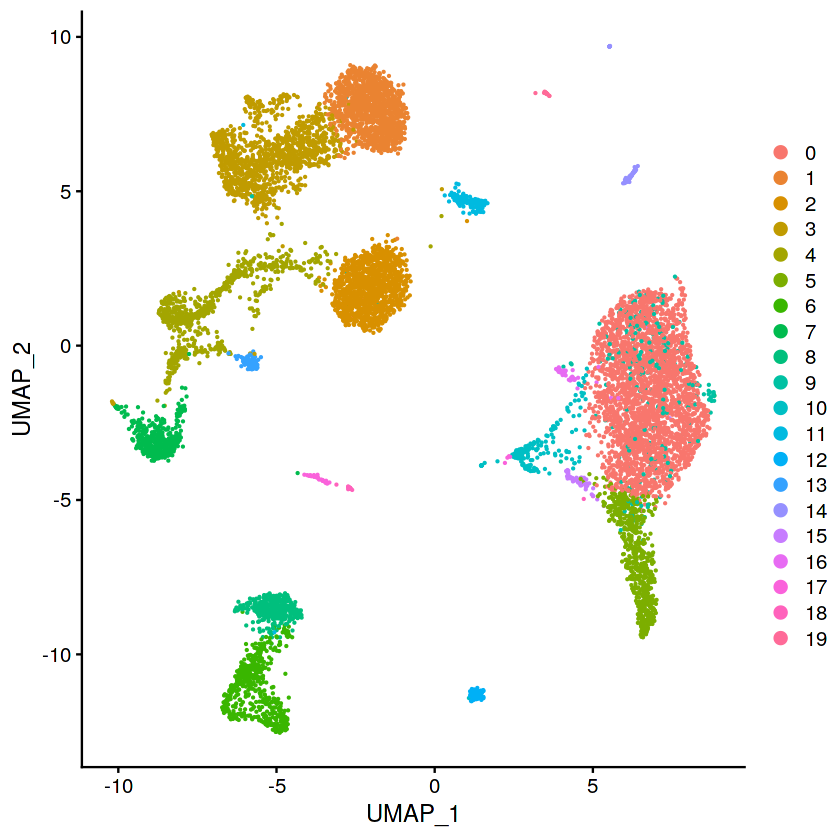

In [127]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label individual clusters
DimPlot(pbmc, reduction = "umap")

In [128]:
pdf( paste0( outputRoot, "05_plot_UMAP.pdf"), width=5, height=4.5)
DimPlot(pbmc, reduction = "umap")
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()
dev.off()

png 
  2

### Run tSNE

In [129]:
pbmc <- RunTSNE(pbmc, dims = 1:37)

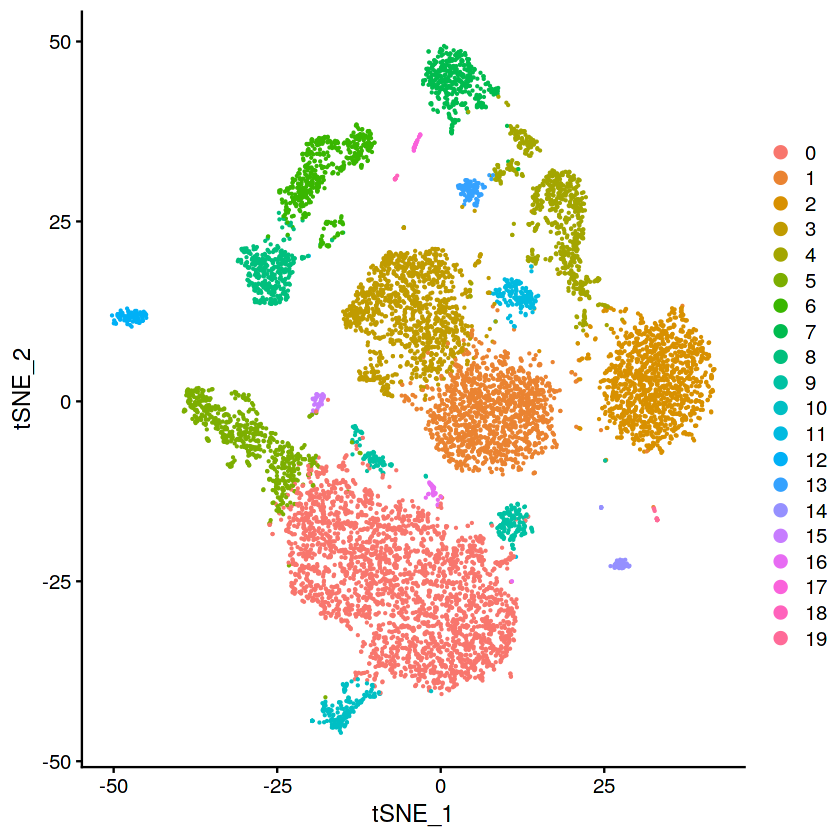

In [130]:
DimPlot(pbmc, reduction = "tsne")

In [131]:
pdf( paste0(outputRoot, "06_plot_tSNE.pdf"), width=5, height=4.5)
DimPlot(pbmc, reduction = "tsne")
DimPlot(pbmc, reduction = "tsne", label = TRUE, pt.size = 0.5) + NoLegend()
dev.off()

png 
  2

### save obj

In [132]:
saveRDS(pbmc, file = paste0(outputRoot, "pbmc_10k_afterUMAP_tSNE.rds") ) # long time! 

## finding cluster biomarkers

### cluster vs other

In [133]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

p_val avg_logFC pct.1 pct.2 p_val_adj
TCF7   0     0.8649709 0.929 0.380 0        
CCR7   0     0.8575966 0.872 0.297 0        
LEF1   0     0.8296585 0.853 0.267 0        
LDHB   0     0.8289311 0.996 0.749 0        
BCL11B 0     0.8222814 0.918 0.402 0

### cluster 1 vs 2

In [134]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

p_val avg_logFC pct.1 pct.2 p_val_adj
FCGR3A 0     2.4751896 0.937 0.192 0        
CDKN1C 0     2.1633929 0.728 0.040 0        
RHOC   0     1.2162153 0.864 0.141 0        
HES4   0     1.0281018 0.815 0.072 0        
ABI3   0     0.9448795 0.963 0.307 0

### find markers for every cluster

In [135]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC) # long time!

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19



p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster gene      
1   0.000000e+00 3.2038834 1.000 0.410  0.000000e+00 0       S100A8    
2   0.000000e+00 3.0587317 1.000 0.565  0.000000e+00 0       S100A9    
3   0.000000e+00 0.8649709 0.929 0.380  0.000000e+00 1       TCF7      
4   0.000000e+00 0.8575966 0.872 0.297  0.000000e+00 1       CCR7      
5   0.000000e+00 1.6439757 0.984 0.093  0.000000e+00 2       CD8B      
6   0.000000e+00 1.3316971 0.736 0.035  0.000000e+00 2       LINC02446 
7   0.000000e+00 1.1962813 0.994 0.505  0.000000e+00 3       IL32      
8   0.000000e+00 1.1485126 0.998 0.683  0.000000e+00 3       LTB       
9   0.000000e+00 2.4886596 0.961 0.153  0.000000e+00 4       CCL5      
10  0.000000e+00 2.0393310 0.626 0.054  0.000000e+00 4       GZMH      
11  0.000000e+00 2.1948709 0.937 0.182  0.000000e+00 5       FCGR3A    
12  0.000000e+00 2.1684786 0.728 0.033  0.000000e+00 5       CDKN1C    
13  0.000000e+00 2.1523504 0.996 0.111  0.000000e+00 6       CD79A     
14  0.000000e+00 2.1049944 0.996 0.069  0.000000e+00 6       MS4A1     
15  0.000000e+00 3.2795549 1.000 0.190  0.000000e+00 7       GNLY      
16  0.000000e+00 2.7555585 0.998 0.257  0.000000e+00 7       NKG7      
17  0.000000e+00 2.7163104 0.997 0.159  0.000000e+00 8       IGHM      
18  0.000000e+00 2.4834495 0.949 0.024  0.000000e+00 8       TCL1A     
19  3.095039e-60 0.6744338 0.996 0.559  7.075258e-56 9       S100A8    
20  1.110755e-56 0.7385260 1.000 0.674  2.539186e-52 9       S100A9    
21 9.655728e-137 2.0094953 1.000 0.351 2.207300e-132 10      HLA-DQA1  
22 2.182105e-107 1.8292356 0.995 0.566 4.988293e-103 10      HLA-DPB1  
23 1.663287e-102 1.6588516 1.000 0.999  3.802275e-98 11      MALAT1    
24 2.229564e-101 1.3041499 1.000 0.999  5.096783e-97 11      MT-CYB    
25 1.110987e-254 2.9004101 0.982 0.090 2.539717e-250 12      GZMB      
26 8.447880e-180 2.9007600 0.469 0.024 1.931185e-175 12      PTGDS     
27 2.029221e-282 1.9209543 0.982 0.069 4.638798e-278 13      GZMK      
28 3.701299e-184 2.5000179 1.000 0.135 8.461170e-180 13      KLRB1     
29  8.815927e-58 1.9507688 0.356 0.030  2.015321e-53 14      CKB       
30  3.177172e-45 1.9175844 0.315 0.030  7.263015e-41 14      PHGDH     
31  2.449705e-69 1.0032047 1.000 0.114  5.600027e-65 15      MS4A1     
32  3.833081e-53 1.0401660 1.000 0.153  8.762423e-49 15      CD79A     
33  2.038950e-29 2.0868335 1.000 0.900  4.661040e-25 16      NEAT1     
34  2.018718e-27 2.0282722 0.977 0.497  4.614789e-23 16      AC020916.1
35  1.058574e-39 2.5087878 1.000 0.230  2.419901e-35 17      STMN1     
36  3.803776e-04 3.0335619 0.281 0.092  1.000000e+00 17      IGHA1     
37  1.780322e-42 5.5580316 0.870 0.090  4.069817e-38 18      IGHA1     
38  1.036069e-09 5.5567418 0.609 0.144  2.368454e-05 18      IGLC2     
39  0.000000e+00 5.6087028 1.000 0.010  0.000000e+00 19      PPBP      
40  2.627805e-29 5.1591612 1.000 0.229  6.007162e-25 19      NRGN

In [145]:
genes.marker=pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)
head(genes.marker)

p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene     
1 0     3.2038834 1.000 0.410 0         0       S100A8   
2 0     3.0587317 1.000 0.565 0         0       S100A9   
3 0     0.8649709 0.929 0.380 0         1       TCF7     
4 0     0.8575966 0.872 0.297 0         1       CCR7     
5 0     1.6439757 0.984 0.093 0         2       CD8B     
6 0     1.3316971 0.736 0.035 0         2       LINC02446

#### several tests for differential expression

In [146]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)
# test.use, DEseq2特别、特别慢，谨慎使用。

### VlnPlot

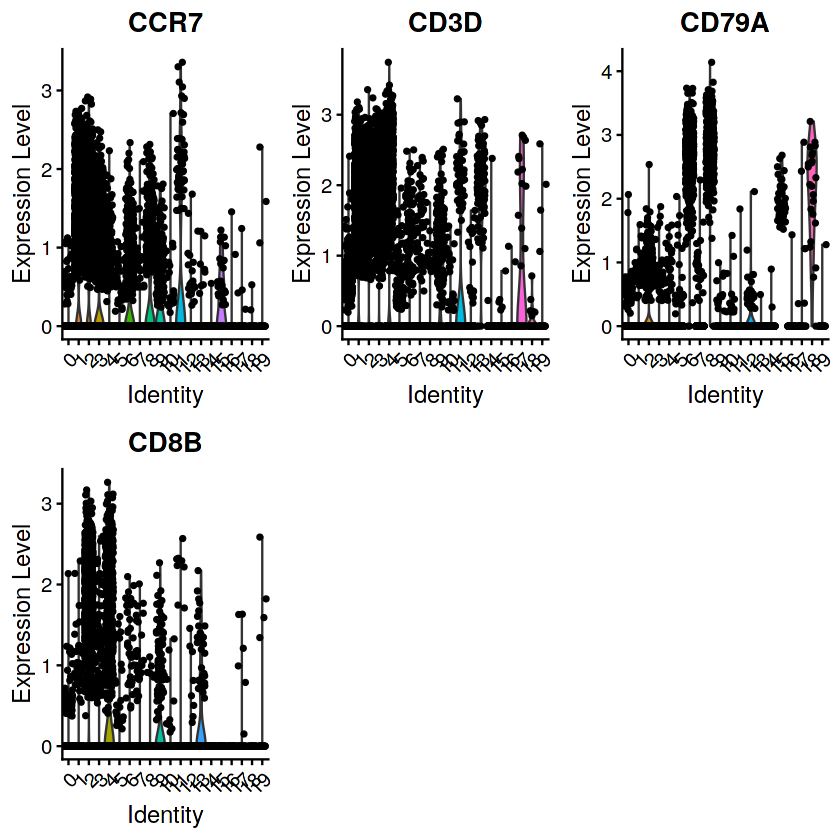

In [147]:
VlnPlot(pbmc, features = c("CCR7", 'CD3D', "CD79A", "CD8B"))

In [148]:
pdf( paste0(outputRoot, "07_plot_VlnPlot.pdf"), width=15, height=4.5)
VlnPlot(pbmc, features = c("IL7R", "TRAC", "TCF7"), pt.size = 0.5)
VlnPlot(pbmc, features = c("CCR7", 'CD3D', "CD79A", "CD8B"), ncol = 4, pt.size = 0.5)
dev.off()

png 
  2

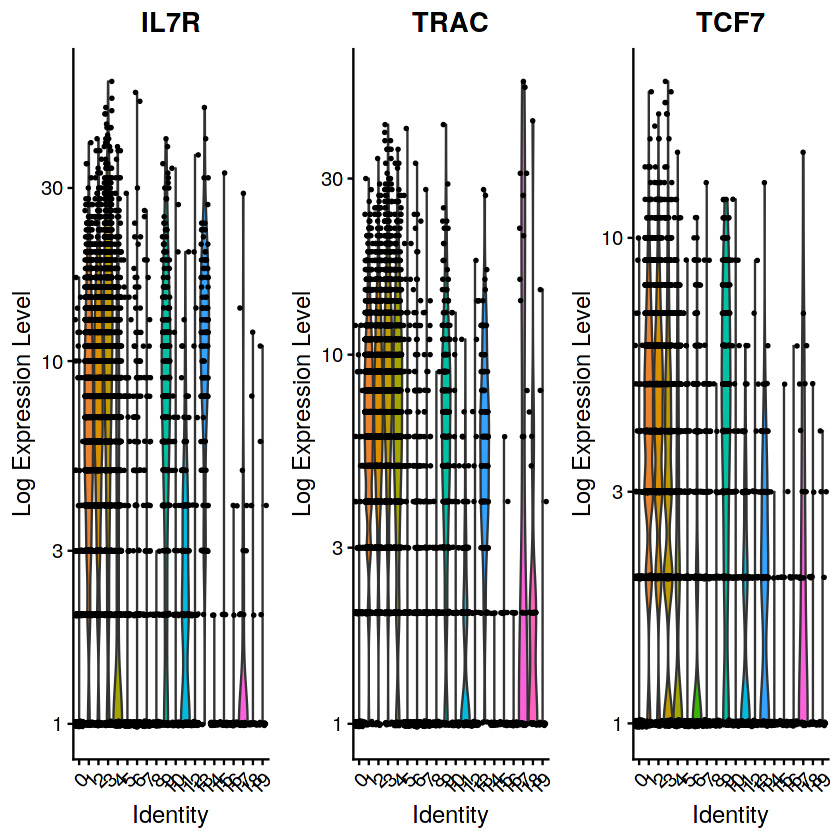

In [149]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("IL7R", "TRAC", "TCF7"), slot = "counts", log = TRUE, pt.size = 0.5)

In [150]:
pdf(  paste0(outputRoot, "07_plot_VlnPlot_counts.pdf"), width=15, height=4.5)
VlnPlot(pbmc, features = c("IL7R", "TRAC", "TCF7"), slot = "counts", log = TRUE, pt.size = 0.5)
dev.off()

png 
  2

### FeaturePlot

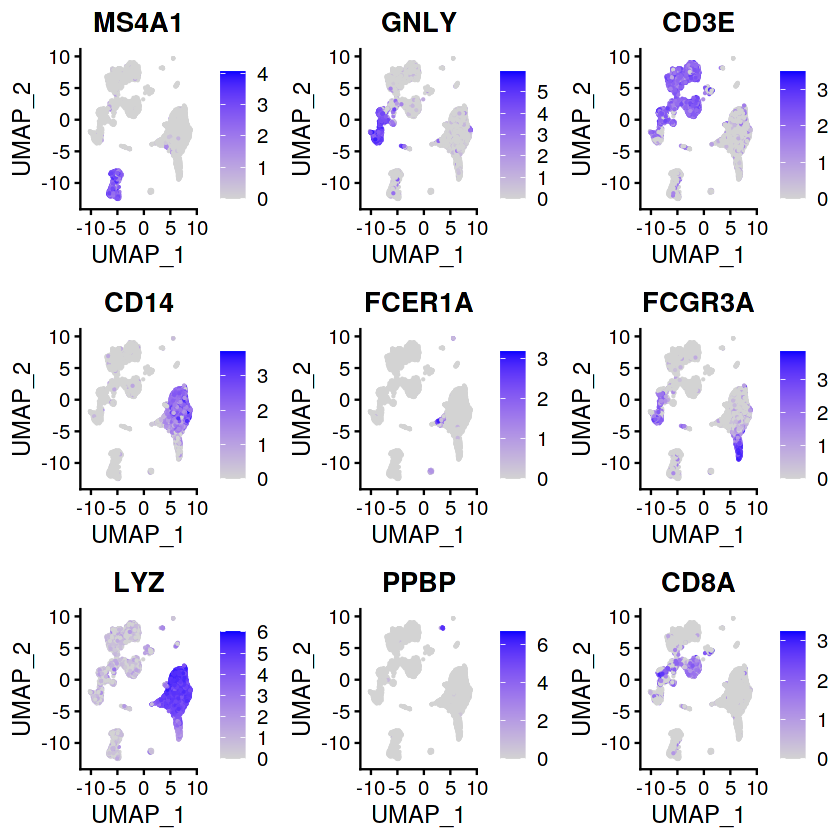

In [151]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"))

In [152]:
pdf( paste0(outputRoot,"08_plot_FeaturePlot.pdf"), width=10, height=10)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"))
dev.off()

png 
  2

In [153]:
pdf( paste0(outputRoot, "08_plot_FeaturePlot-2.pdf"), width=15, height=30)
FeaturePlot(pbmc, features = genes.marker$gene)
dev.off()

png 
  2

####  FeaturePlot: reduction = "tsne"

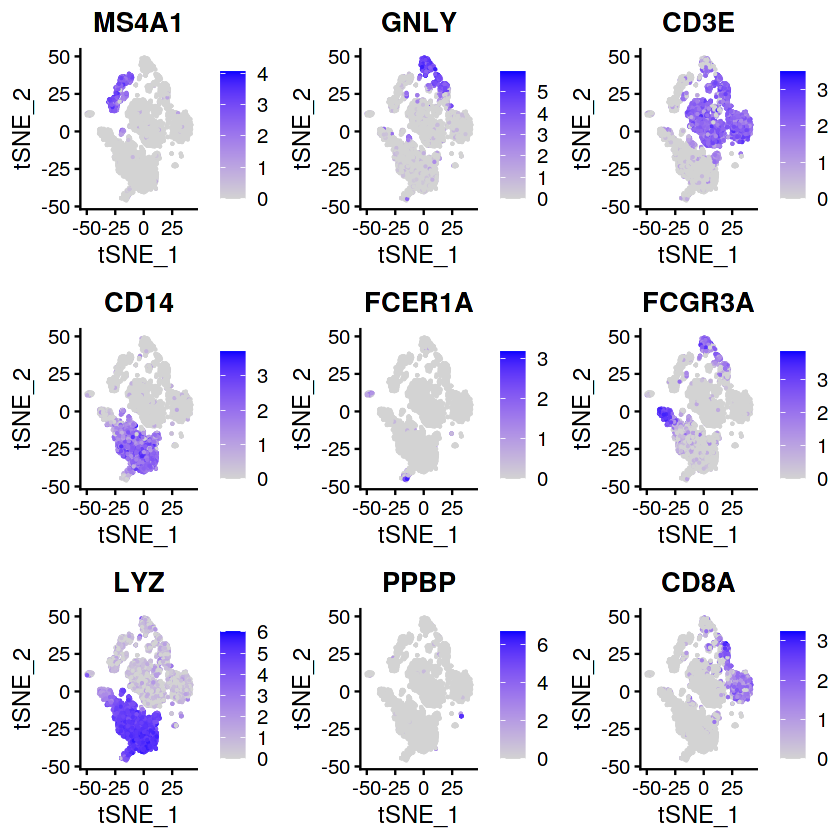

In [154]:
# FeaturePlot
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"), reduction = "tsne")

In [155]:
pdf( paste0(outputRoot, "08_plot_FeaturePlot_tSNE.pdf"), width=10, height=10)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"), reduction = "tsne")
dev.off()

png 
  2

In [158]:
pdf( paste0(outputRoot, "08_plot_FeaturePlot_tSNE-2.pdf"), width=15, height=25)
FeaturePlot(pbmc, features = genes.marker$gene, reduction = "tsne")
dev.off()

png 
  2

#### FeaturePlot: reduction = "pca"

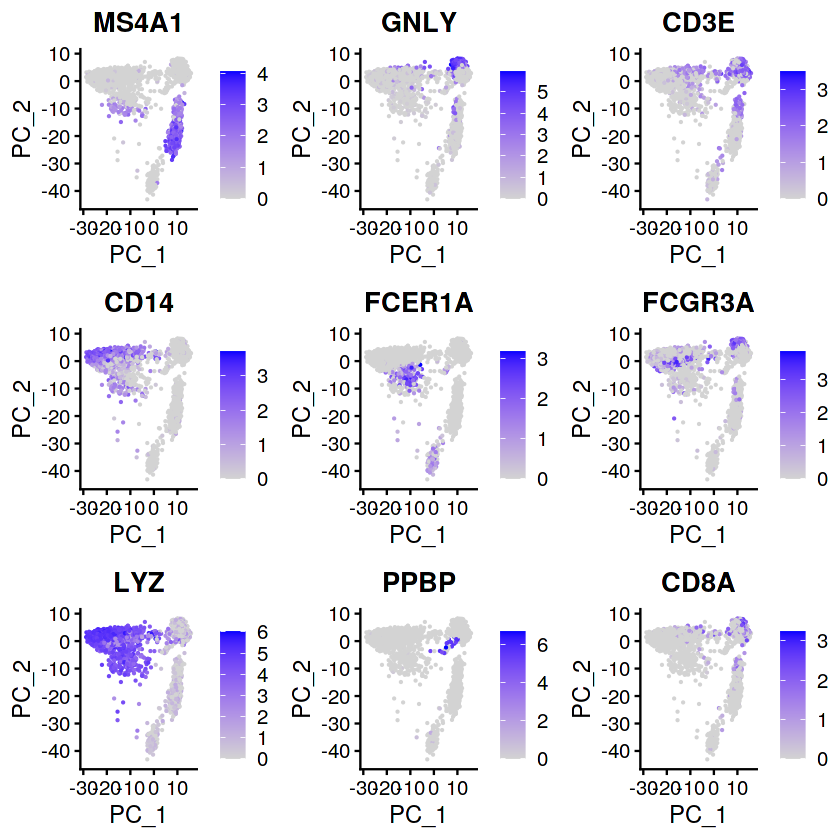

In [159]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"), reduction = "pca")

In [160]:
pdf( paste0(outputRoot, "08_plot_FeaturePlot_pca.pdf"), width=10, height=10)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",  "CD8A"), reduction = "pca")
dev.off()

png 
  2

### DoHeatmap

In [161]:
head(pbmc.markers)

p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene   
S100A8  0     3.203883  1.000 0.410 0         0       S100A8 
S100A9  0     3.058732  1.000 0.565 0         0       S100A9 
LYZ     0     2.636891  1.000 0.569 0         0       LYZ    
S100A12 0     2.248656  0.950 0.093 0         0       S100A12
VCAN    0     2.211116  0.973 0.147 0         0       VCAN   
MNDA    0     2.205240  0.999 0.227 0         0       MNDA

In [162]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
dim(top10)

[1] 200   7

In [163]:
length((top10$gene))
length(unique(top10$gene))

[1] 200

[1] 149

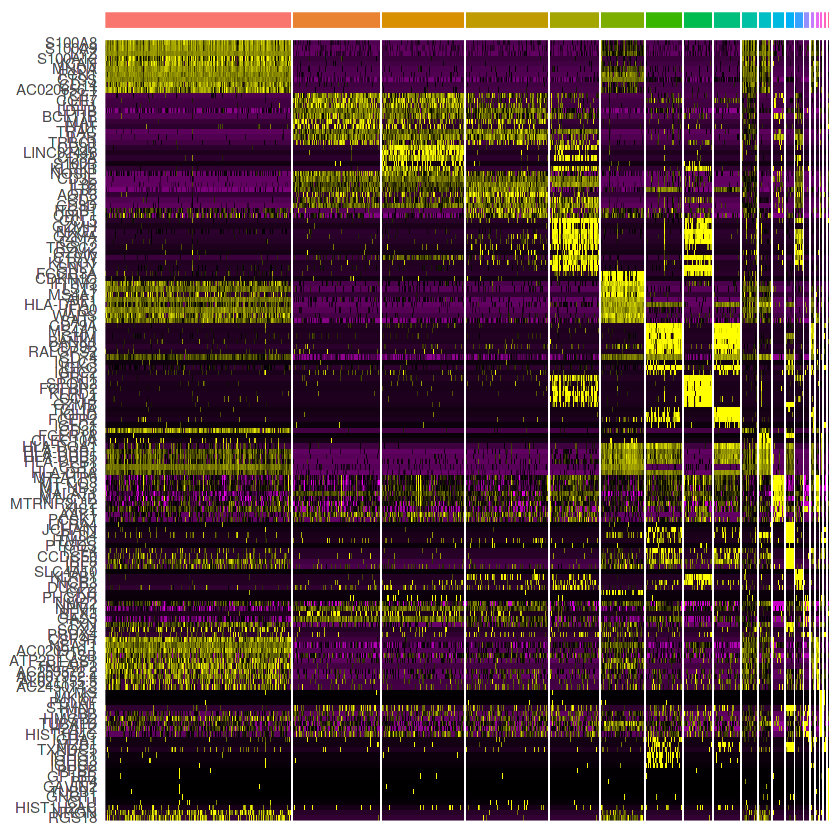

In [167]:
DoHeatmap(pbmc, features = top10$gene, label = F )  + NoLegend()

In [168]:
pdf( paste0(outputRoot, "09_plot_DoHeatmap.pdf"), width=20, height=20)
DoHeatmap(pbmc, features = top10$gene, label = F) + NoLegend()
dev.off()

png 
  2

In [169]:
table(pbmc@meta.data$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2807 1322 1252 1242  744  654  542  437  389  232  188  170  113  109   73   46 
  16   17   18   19 
  43   32   23   23 

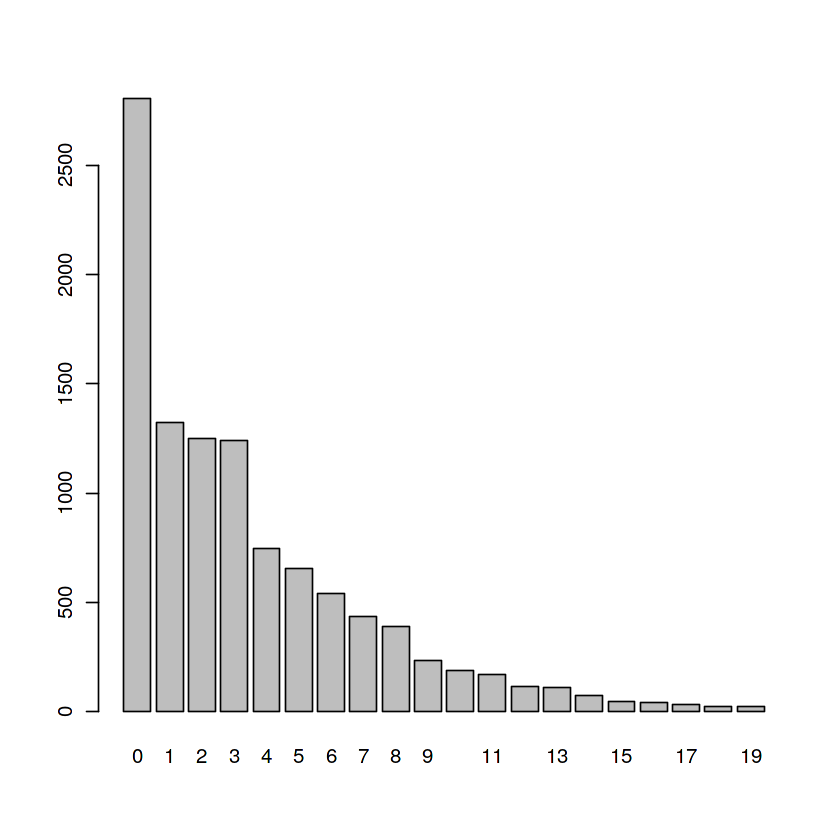

In [170]:
barplot(table(pbmc@meta.data$seurat_clusters))

### dotPlot

In [171]:
length(top10$gene)

[1] 200

In [172]:
top5 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

In [173]:
length(top5$gene)
as.character( top5$gene )

[1] 100

[1] "S100A8"     "S100A9"     "LYZ"        "S100A12"    "VCAN"      
  [6] "TCF7"       "CCR7"       "LEF1"       "LDHB"       "TRBC1"     
 [11] "CD8B"       "LINC02446"  "CD8A"       "S100B"      "CCR7"      
 [16] "IL32"       "LTB"        "IL7R"       "TRAC"       "ITGB1"     
 [21] "CCL5"       "GZMH"       "NKG7"       "GZMA"       "GNLY"      
 [26] "FCGR3A"     "CDKN1C"     "IFITM3"     "LST1"       "MS4A7"     
 [31] "CD79A"      "MS4A1"      "IGHM"       "BANK1"      "IGKC"      
 [36] "GNLY"       "NKG7"       "PRF1"       "SPON2"      "FGFBP2"    
 [41] "IGHM"       "TCL1A"      "IGHD"       "CD79A"      "MS4A1"     
 [46] "VCAN"       "S100A12"    "S100A8"     "S100A9"     "LYZ"       
 [51] "HLA-DQA1"   "HLA-DRB1"   "HLA-DPB1"   "HLA-DPA1"   "HLA-DRA"   
 [56] "MT-ATP6"    "MALAT1"     "MT-CYB"     "BCL11B"     "XIST"      
 [61] "GZMB"       "PLD4"       "ITM2C"      "PTGDS"      "TCF4"      
 [66] "GZMK"       "KLRB1"      "KLRG1"      "NCR3"       "GZMA"      
 [71] "CKB"        "PHGDH"      "NME2"       "XIST"       "PRDX4"     
 [76] "MS4A1"      "IGHD"       "CD79A"      "IGHM"       "HLA-DRA"   
 [81] "CSF3R"      "NEAT1"      "AC020916.1" "AC253572.2" "AC007952.4"
 [86] "STMN1"      "HMGB2"      "TUBA1B"     "HIST1H4C"   "IGHA1"     
 [91] "JCHAIN"     "IGHA1"      "IGHG2"      "IGKC"       "IGLC2"     
 [96] "PPBP"       "GP1BB"      "PF4"        "HIST1H2AC"  "NRGN"

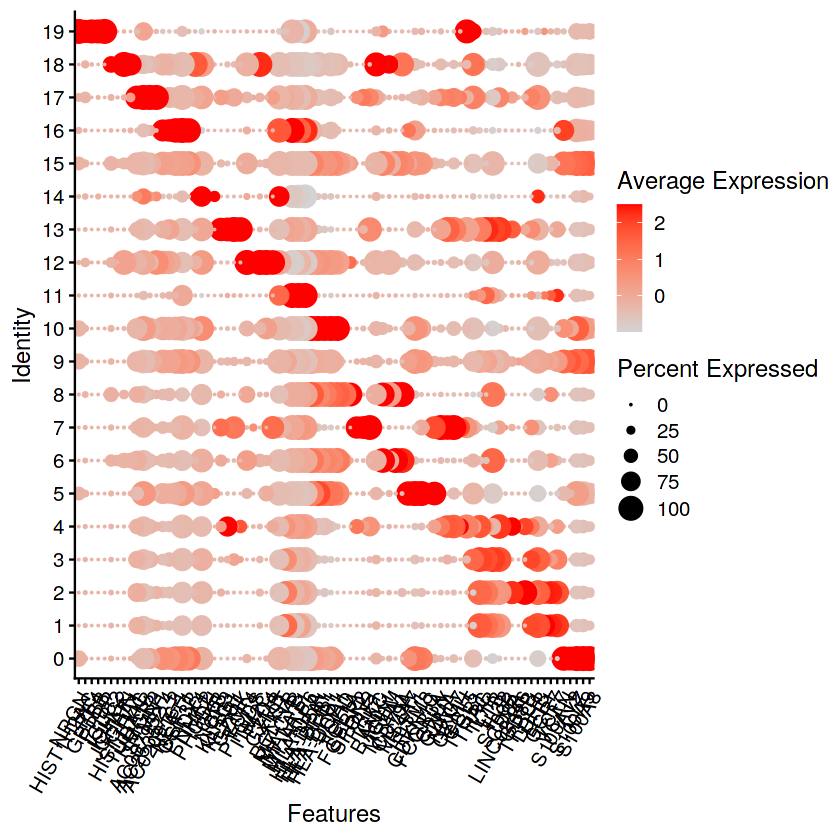

In [174]:
library(ggplot2)
DotPlot(pbmc, features = unique( top5$gene ), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

In [179]:
pdf( paste0(outputRoot, "10_plot_DotPlot.pdf"), width=17, height=6)
DotPlot(pbmc, features = rev(unique( top5$gene )), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )
dev.off()

png 
  2

In [178]:
pdf(paste0(outputRoot,"10_plot_DotPlot-cellCycle.pdf"), width=9, height=6)
DotPlot(pbmc, features = unique( c("CCNE1","CCNE2", "CCNB1","CCNB2","CCND1","CCND2","CCND3", "CCNA2", "PLK1", "MKI67",
                                   'CDC25A','CDC25C','CCDC25','CDC25B',
                                   "GAPDH","PDCD1","CD274", "TIGIT", "CD47", "EGF", "TP53", "EMP1", 'EMP3',"PTEN",
                                   "GRB10","UBFD1","IFT20" ) ), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )
dev.off()

png 
  2

In [180]:
pbmc #10441  samples

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

#### search gene names

In [186]:
searchGene=function(pattern="^CCN"){
    rownames( pbmc@assays$RNA)[ grep(pattern, rownames( pbmc@assays$RNA) ) ]
}
# test
searchGene()

[1] "CCNL2"     "CCNT2-AS1" "CCNT2"     "CCNYL1"    "CCNL1"     "CCNI"     
 [7] "CCNG2"     "CCNA2"     "CCNB1"     "CCNH"      "CCNI2"     "CCNJL"    
[13] "CCNG1"     "CCND3"     "CCNC"      "CCN6"      "CCN2"      "CCNE2"    
[19] "CCN3"      "CCNY"      "CCNJ"      "CCND1"     "CCND2-AS1" "CCND2"    
[25] "CCNT1"     "CCNB1IP1"  "CCNK"      "CCNDBP1"   "CCNB2"     "CCNF"     
[31] "CCNE1"     "CCN5"      "CCNB3"     "CCNQ"

## 细胞类型鉴定

### 人工鉴定细胞类型

Assigning cell type identity to clusters

人工鉴定细胞类型
* CellMarker：http://biocc.hrbmu.edu.cn/CellMarker/index.jsp
* PanglaoDB：https://panglaodb.se/index.html



png 
  2

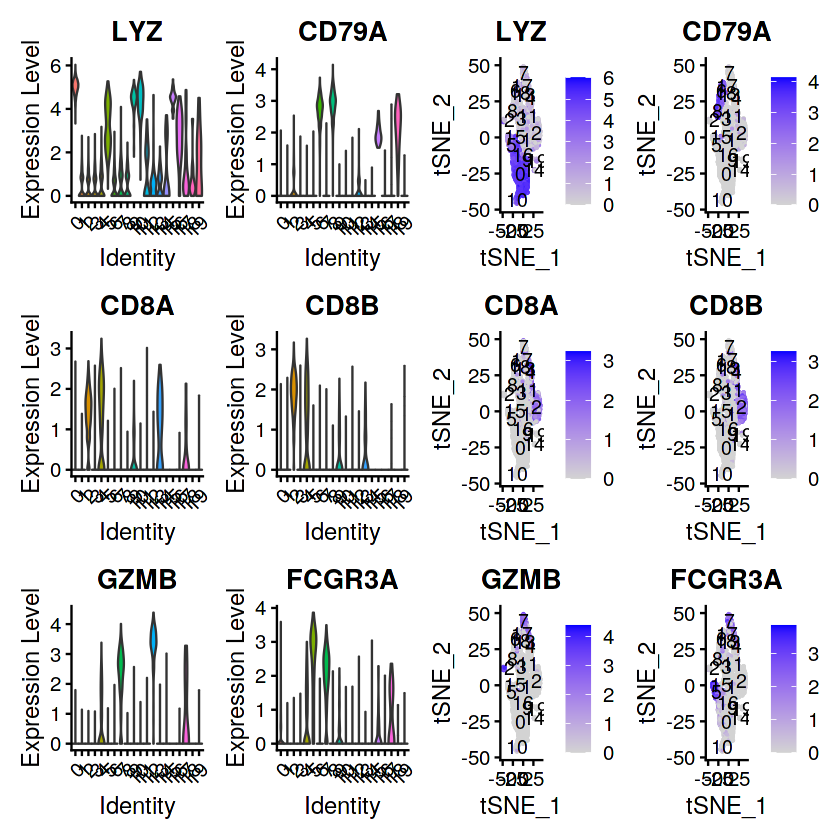

In [301]:
#挑选部分基因
select_genes <- c('LYZ','CD79A','CD8A','CD8B','GZMB','FCGR3A')
#vlnplot展示
#p1 <- VlnPlot(pbmc, features = select_genes, pt.size=0, group.by="celltype", ncol=2)
p1 <- VlnPlot(pbmc, features = select_genes, pt.size=0,  ncol=2)
#featureplot展示
p2 <- FeaturePlot(pbmc, features = select_genes, reduction = "tsne", label=T, ncol=2)

p3=p1|p2
print( p3 )

pdf(paste0(outputRoot, "11-selectgenes_VlnPlot_FeaturePlot.pdf"), width=13, height=10)
print( p3 )
dev.off()

#### determin cluster 9

png 
  2

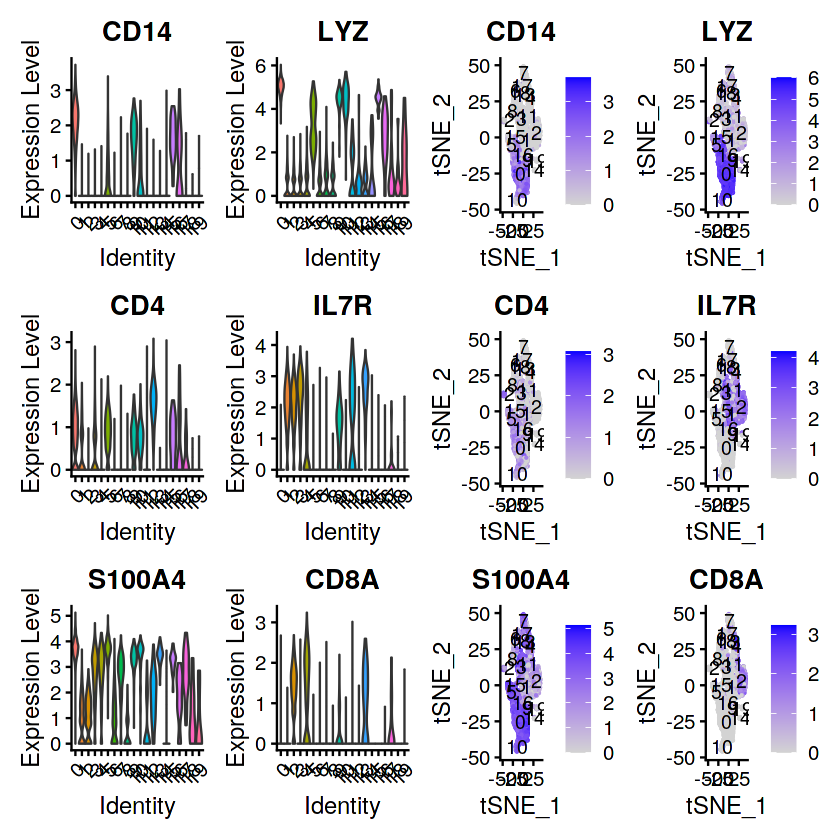

In [308]:
#for cluster 9
select_genes <- c('CD14','LYZ','CD4','IL7R','S100A4','CD8A')
#vlnplot展示
#p1 <- VlnPlot(pbmc, features = select_genes, pt.size=0, group.by="celltype", ncol=2)
p1 <- VlnPlot(pbmc, features = select_genes, pt.size=0,  ncol=2)
#featureplot展示
p2 <- FeaturePlot(pbmc, features = select_genes, reduction = "tsne", label=T, ncol=2)

p3=p1|p2
print( p3 )

pdf(paste0(outputRoot, "11-selectgenes_VlnPlot_FeaturePlot-C9.pdf"), width=13, height=10)
print( p3 )
dev.off()

png 
  2

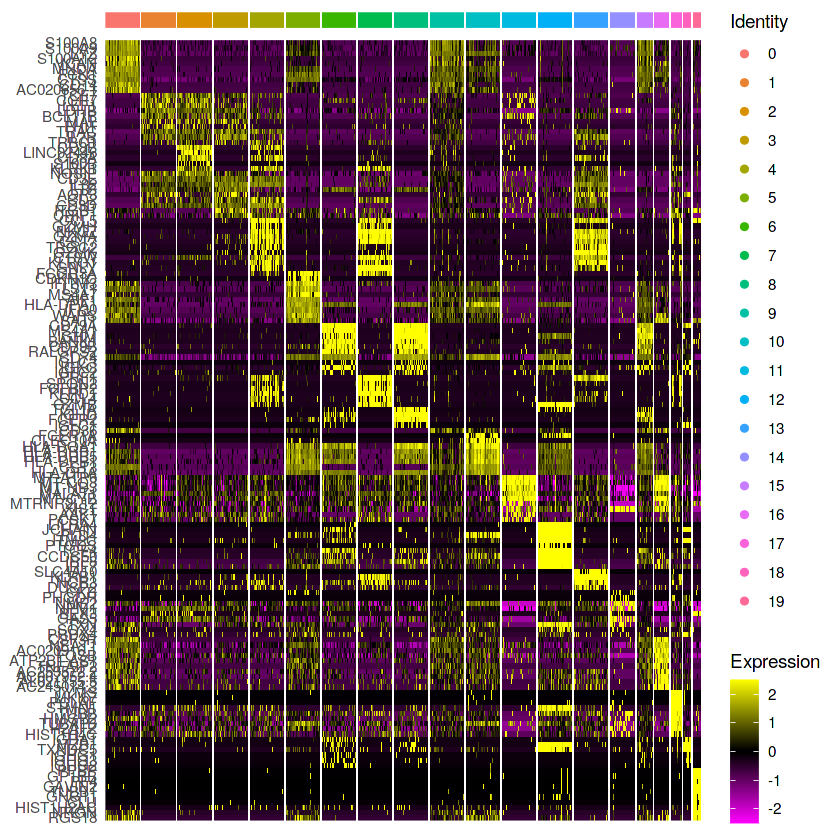

In [481]:
DoHeatmap( subset(pbmc,  downsample=100 ), features = top10$gene, label = F)

pdf(paste0(outputRoot, "11-heatmap_downsample100.pdf"), width=9, height=13)
DoHeatmap( subset(pbmc,  downsample=100 ), features = top10$gene, label = F)+ theme(text = element_text(size = 9))
dev.off()

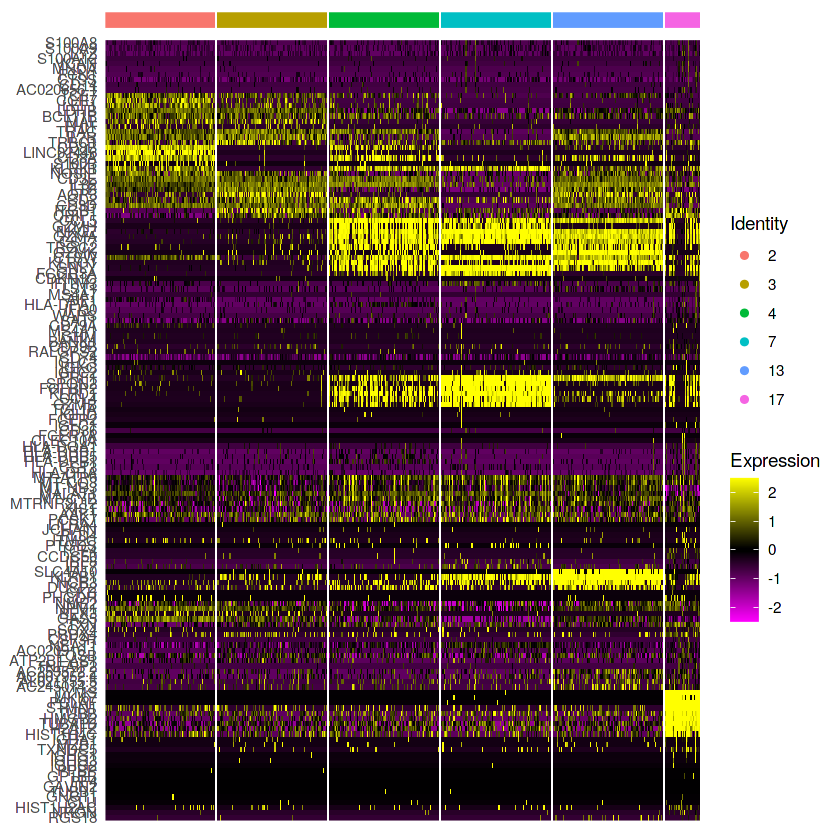

In [484]:
DoHeatmap( subset(pbmc,  idents =c(2,3,4,7,13,17), downsample=100 ), features = top10$gene, label = F)

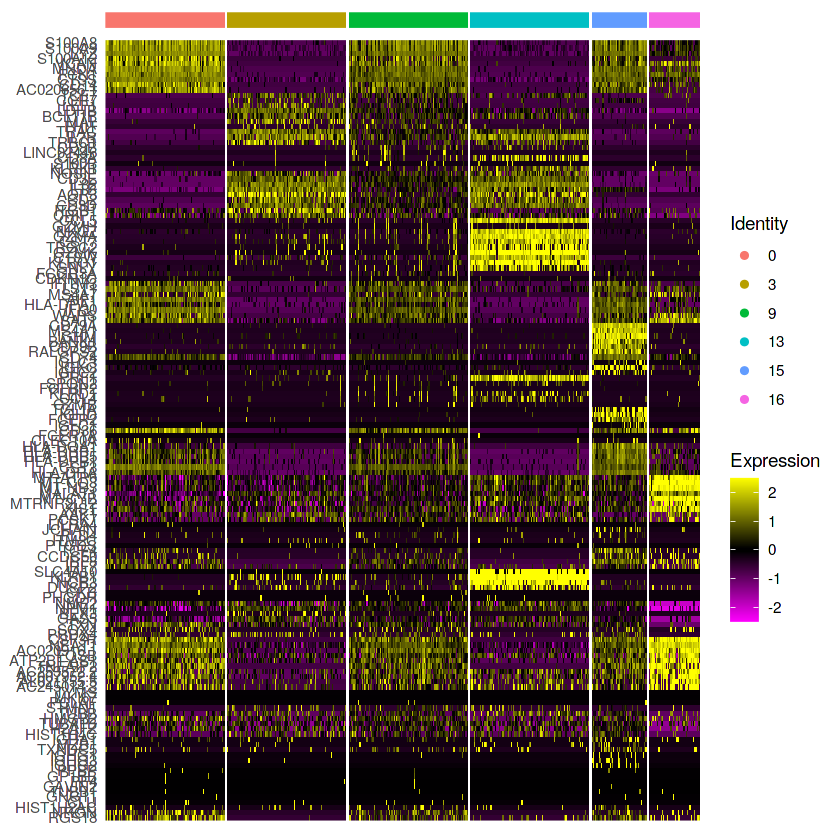

In [482]:
DoHeatmap( subset(pbmc,  idents =c(0,3,9,13,15,16), downsample=100 ), features = top10$gene, label = F)
# 9 more like 0,15
# 9 not like 3, 13

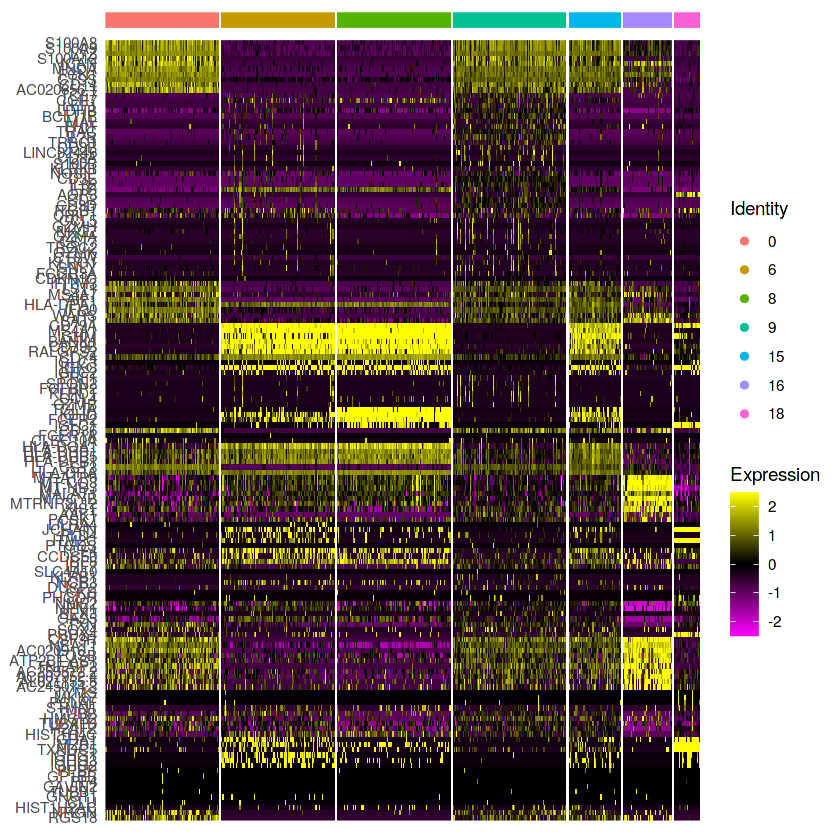

In [474]:
DoHeatmap( subset(pbmc,  idents =c(0,6,8,9,15, 16,18), downsample=100 ), features = top10$gene, label = F)
# 15 more like: 6,8
# 15 not like:0,16

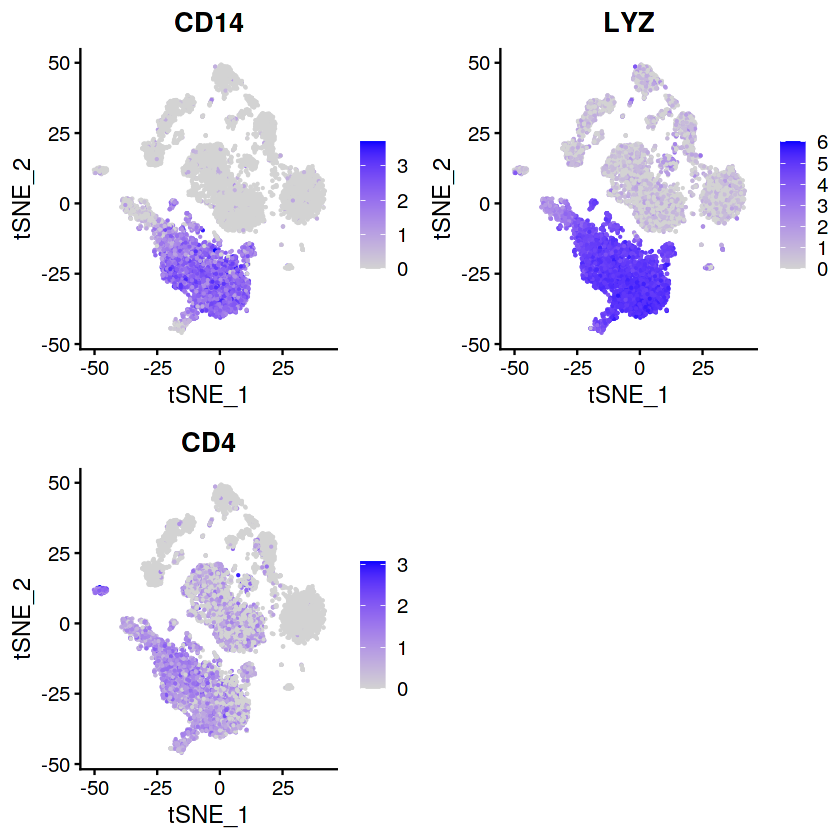

In [226]:
# CD14 mono
FeaturePlot(pbmc, features = c("CD14", "LYZ", "CD4"), reduction = "tsne")

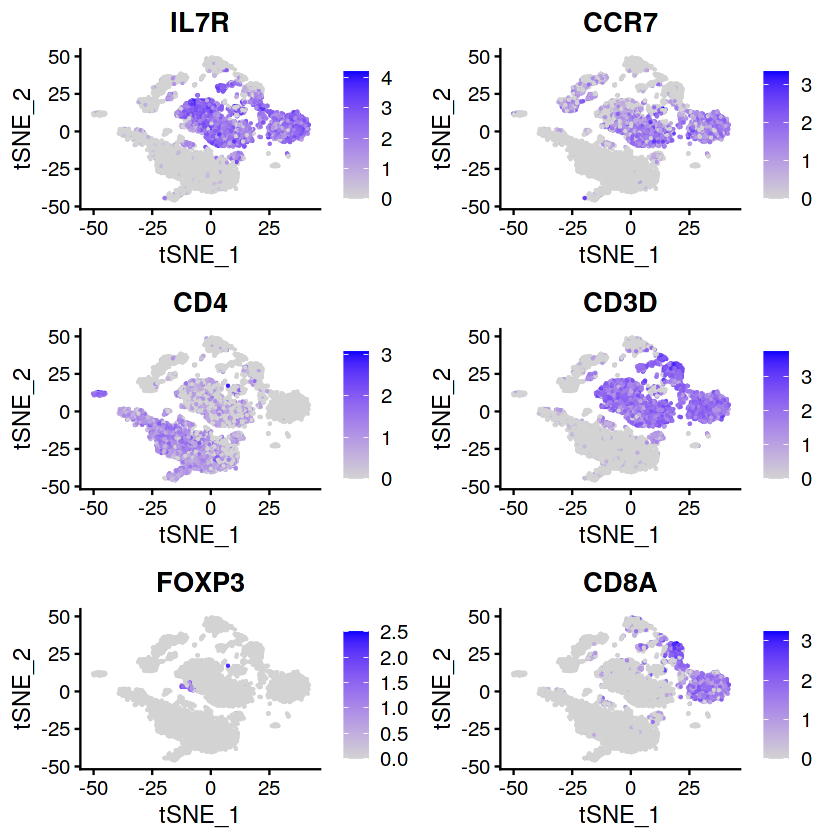

In [227]:
# naive T: IL7R, CCR7
FeaturePlot(pbmc, features = c("IL7R", "CCR7", "CD4","CD3D", "FOXP3","CD8A"), reduction = "tsne")

In [218]:
pdf( paste0(outputRoot, "_assign_naiveT.pdf"), width=10, height=10)
VlnPlot(pbmc, features = c("IL7R", "CCR7", 'CD3D'), reduction = "tsne", ncol = 3)
dev.off()

Warning message in as_grob.default(plot):
“Cannot convert object of class character into a grob.”
Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”
Warning message:
“Graphs cannot be horizontally aligned unless the axis parameter is set. Placing graphs unaligned.”


png 
  2

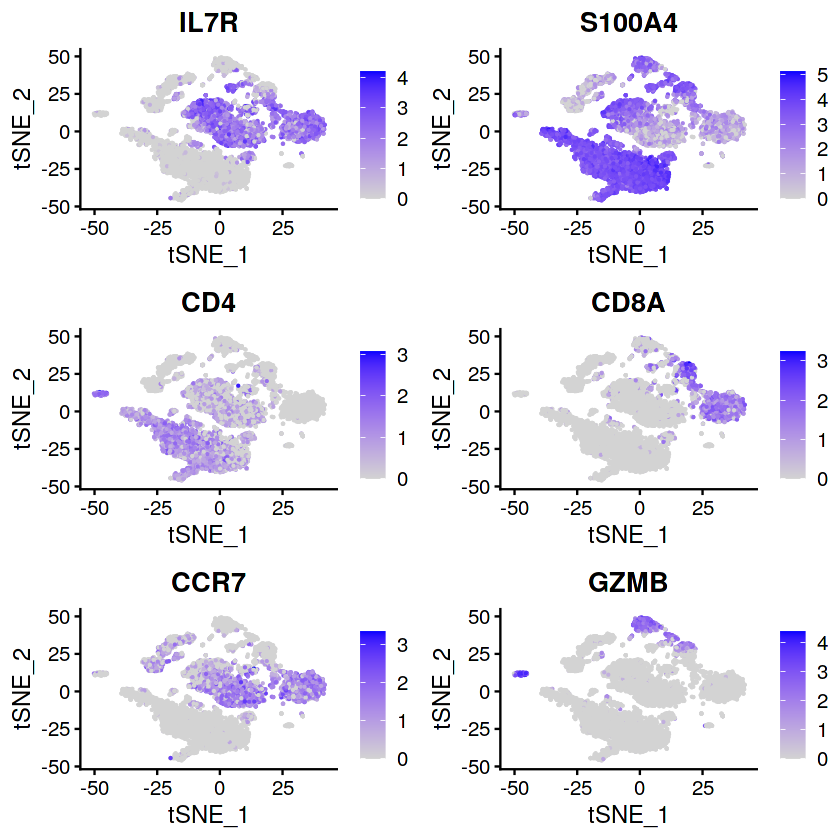

In [471]:
# memory CD4+ T cell
FeaturePlot(pbmc, features = c("IL7R","S100A4",'CD4', "CD8A", "CCR7","GZMB"), reduction = "tsne")

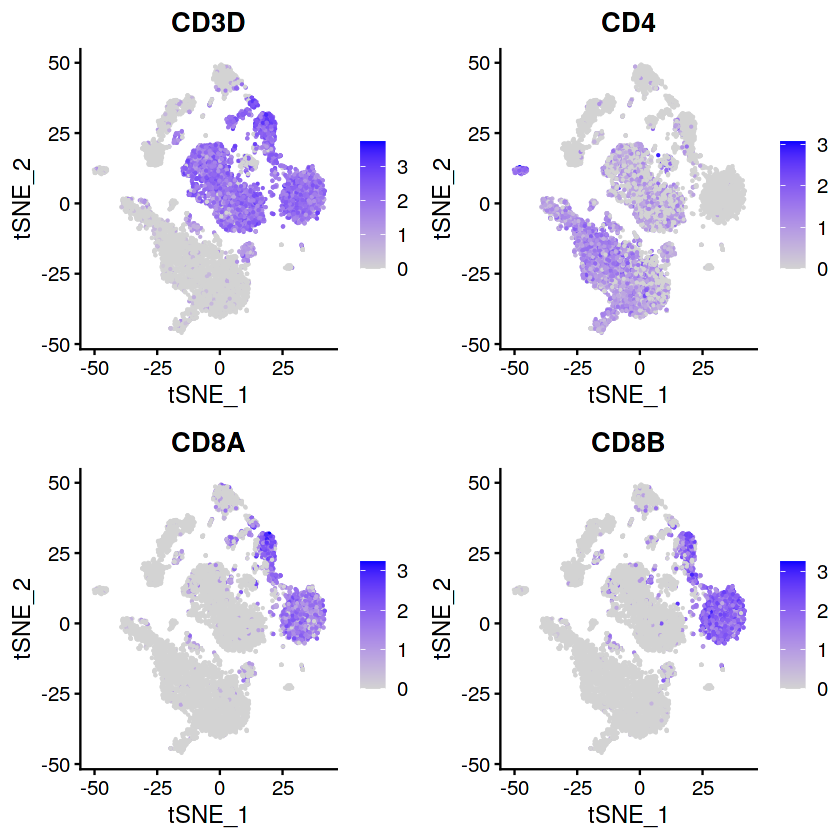

In [184]:
# CD8
FeaturePlot(pbmc, features = c("CD3D","CD4", "CD8A","CD8B"), reduction = "tsne")

In [187]:
searchGene("^GZM")

[1] "GZMK" "GZMA" "GZMH" "GZMB" "GZMM"

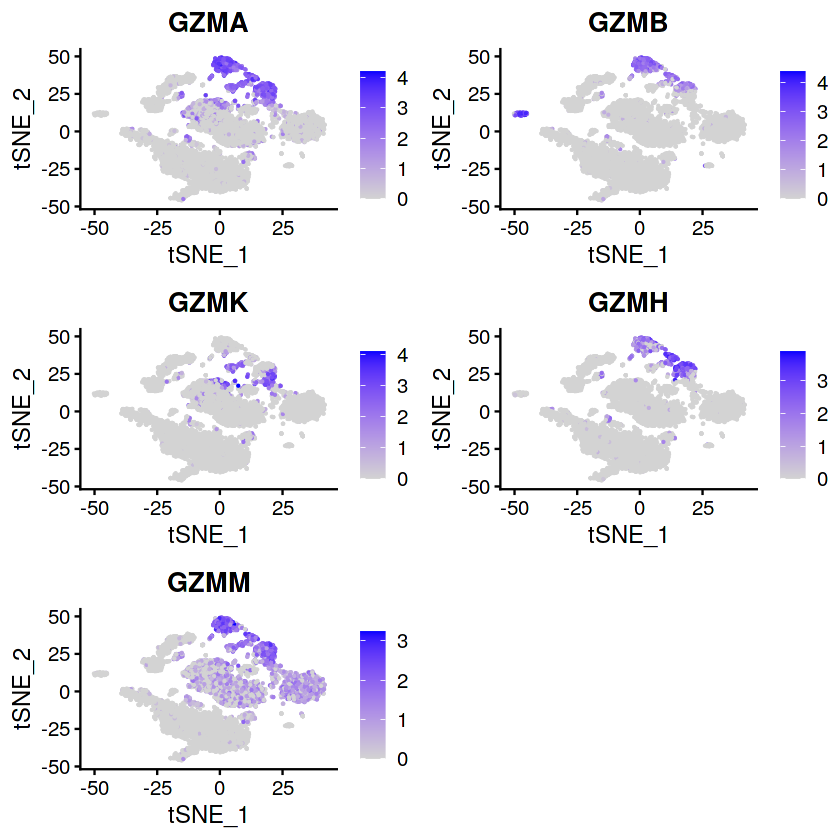

In [188]:
FeaturePlot(pbmc, features = c("GZMA","GZMB", "GZMK","GZMH", "GZMM"), reduction = "tsne")

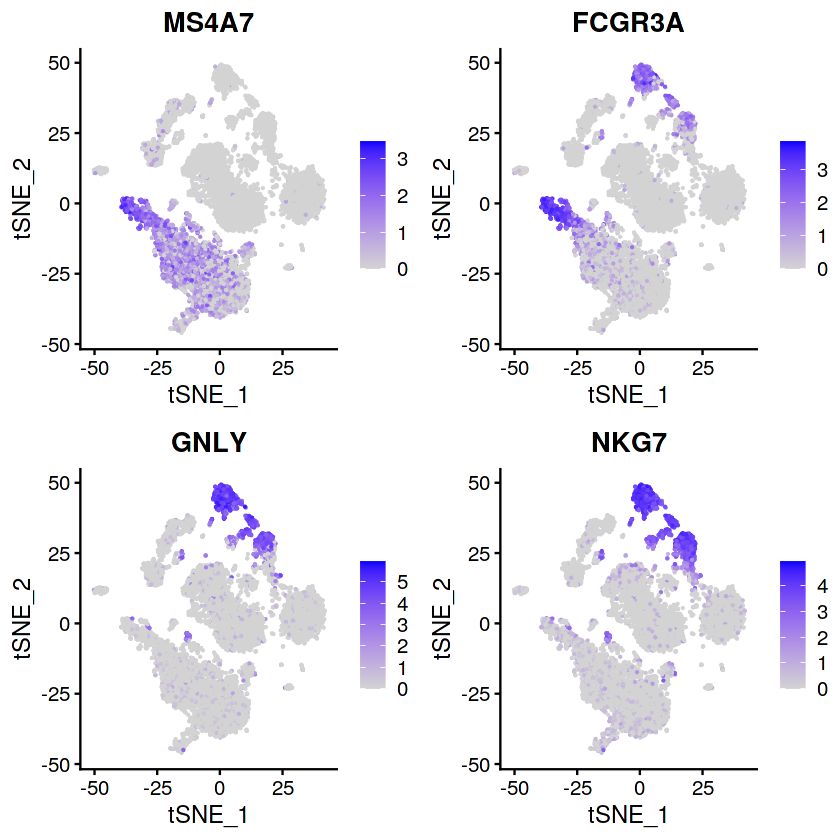

In [189]:
# NK
FeaturePlot(pbmc, features = c("MS4A7","FCGR3A", "GNLY","NKG7"), reduction = "tsne")

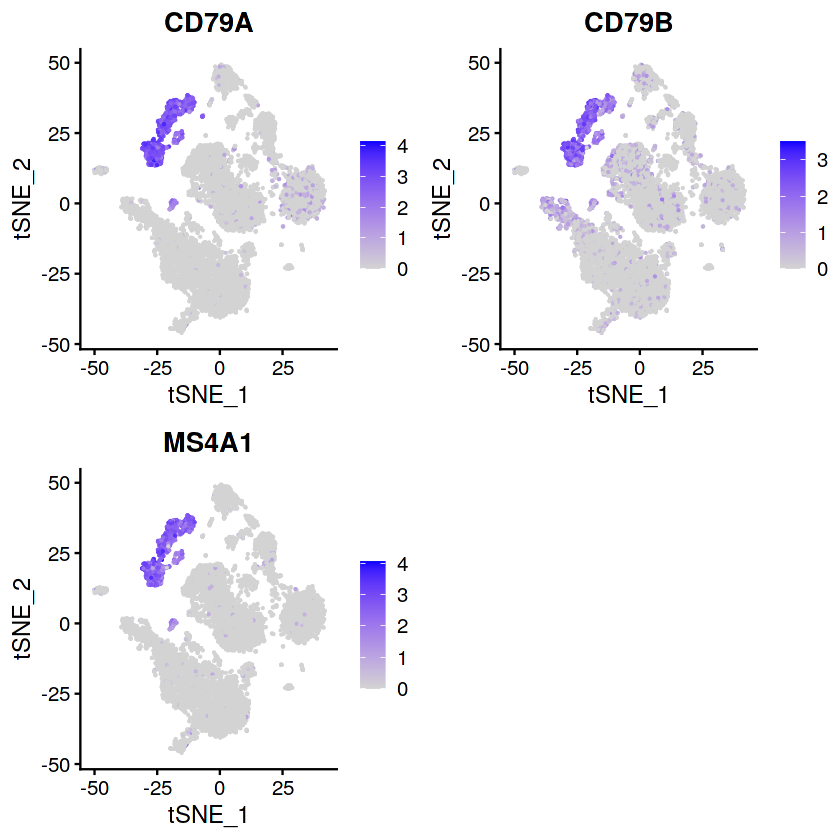

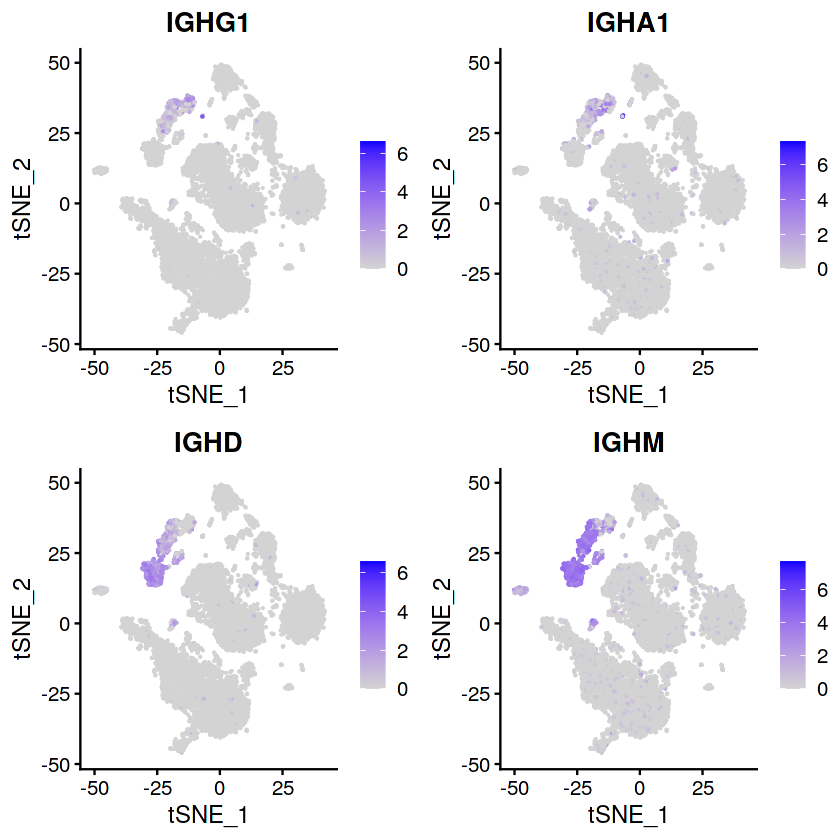

In [192]:
# B cells
FeaturePlot(pbmc, features = c("CD79A","CD79B","MS4A1"), reduction = "tsne")
FeaturePlot(pbmc, features = c("IGHG1", "IGHA1", "IGHD","IGHM"), reduction = "tsne")

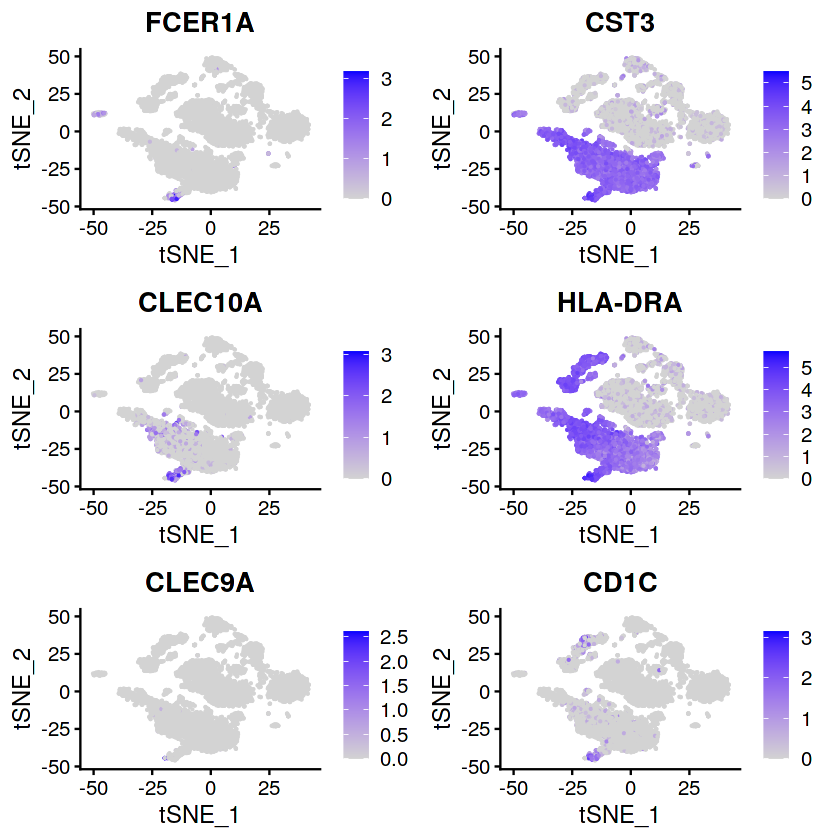

In [193]:
# DC cells
# https://www.researchgate.net/publication/324803234_CLEC10A_Is_a_Specific_Marker_for_Human_CD1c_Dendritic_Cells_and_Enhances_Their_Toll-Like_Receptor_78-Induced_Cytokine_Secretion
FeaturePlot(pbmc, features = c("FCER1A", "CST3", "CLEC10A", "HLA-DRA", "CLEC9A","CD1C"), reduction = "tsne")

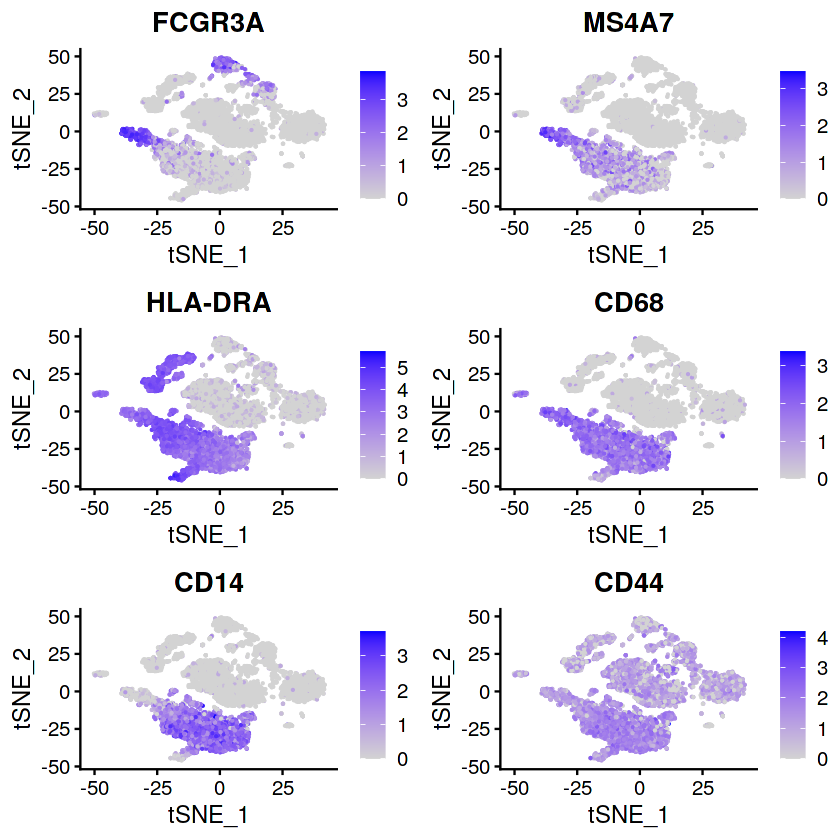

In [198]:
# Macrophase / monocyte
FeaturePlot(pbmc, features = c("FCGR3A",'MS4A7', "HLA-DRA", "CD68", "CD14", "CD44"), reduction = "tsne")

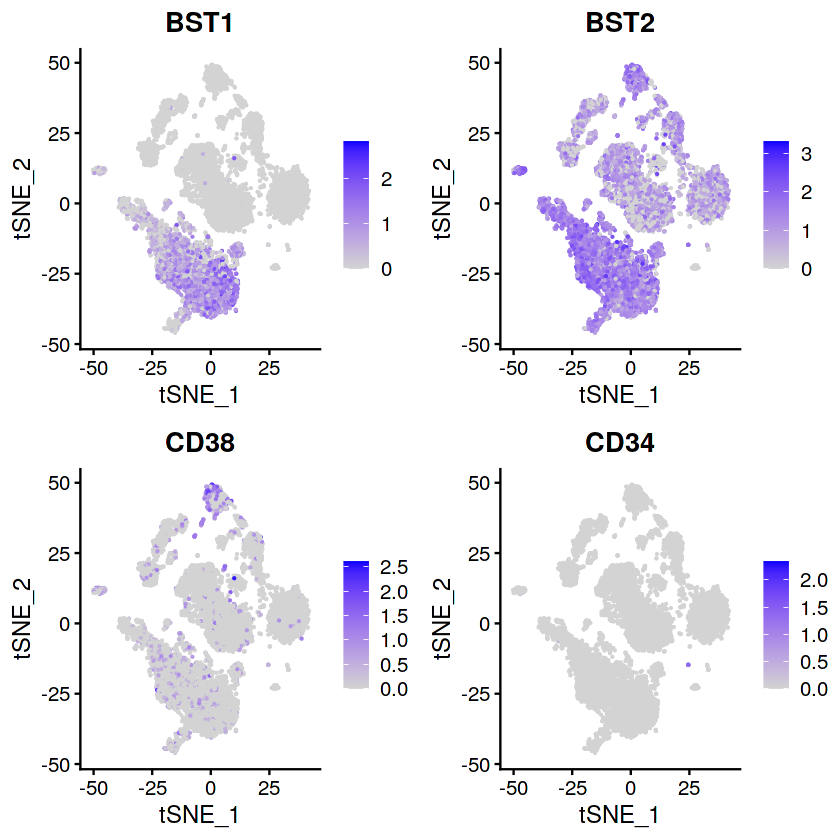

In [199]:
FeaturePlot(pbmc, features = c("BST1", "BST2", "CD38", "CD34"), reduction = "tsne")

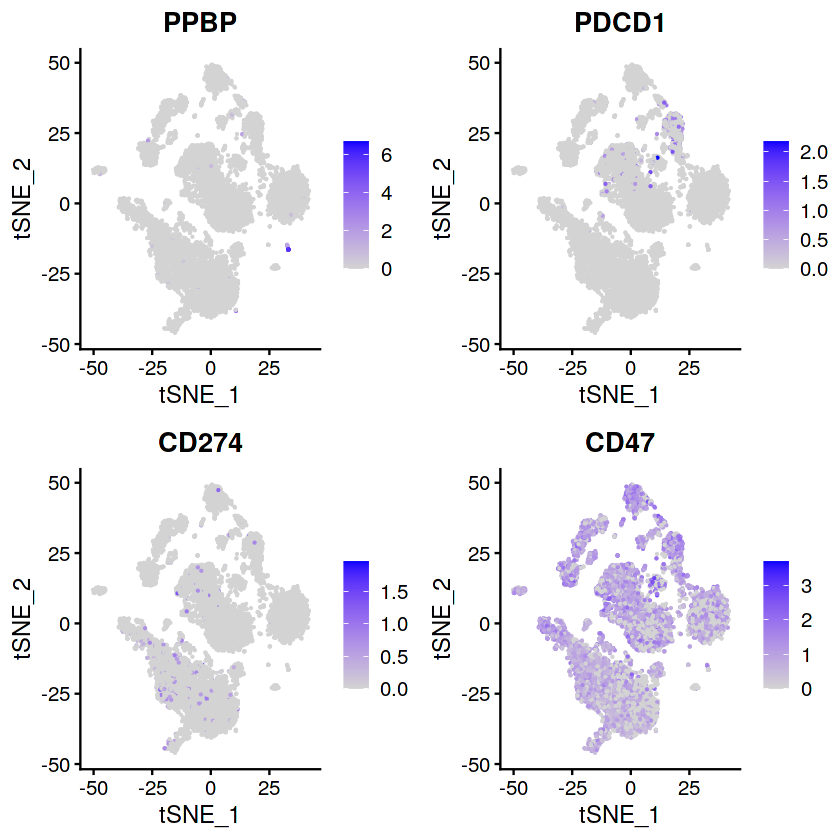

In [232]:
FeaturePlot(pbmc, features = c("PPBP", "PDCD1", "CD274","CD47"), reduction = 'tsne')

In [201]:
pdf( paste0( outputRoot, "08_plot_FeaturePlot_Ig.pdf"), width=12, height=12)
FeaturePlot(pbmc, features = c('IGHEP2', 'IGHMBP2', 'PIGH', 'IGHA2', 'IGHE', 'IGHG4', 'IGHG2', 'IGHGP', 
                               'IGHA1', 'IGHEP1', 'IGHG1', 'IGHG3', 'IGHD', 'IGHM'), reduction = "tsne")
dev.off()

png 
  2

png 
  2

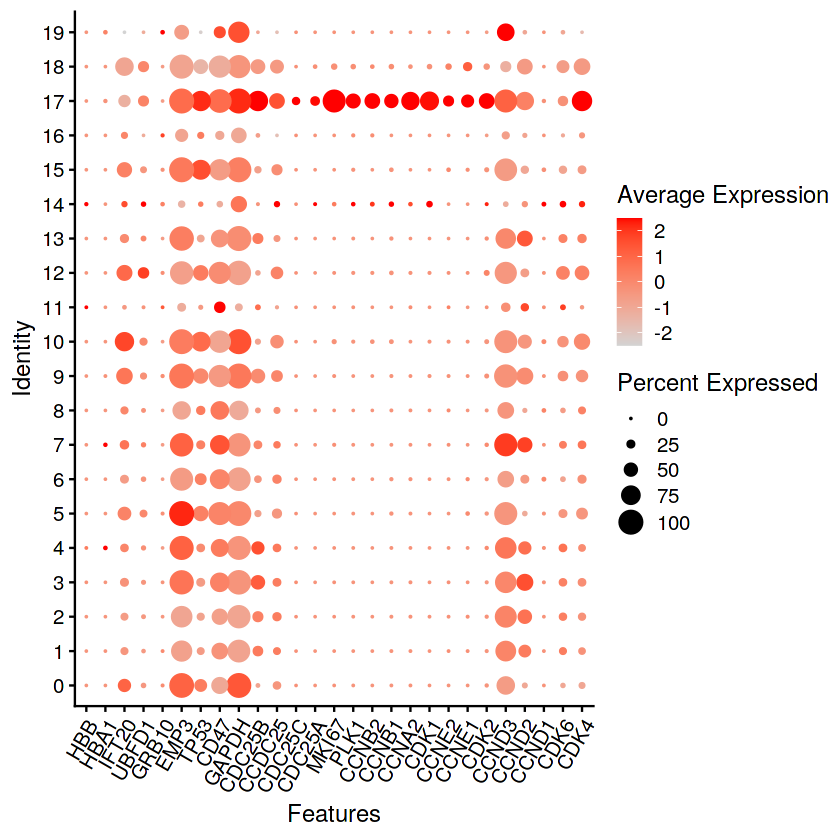

In [251]:
library(ggplot2)
cellCyclePlot=DotPlot(pbmc, features = unique( c("CDK4", "CDK6","CCND1","CCND2","CCND3",
                                   "CDK2","CCNE1","CCNE2", 
                                   "CDK1", "CCNA2", "CCNB1","CCNB2",
                                    "PLK1", "MKI67",
                                   'CDC25A','CDC25C','CCDC25','CDC25B',
                                   "GAPDH","CD47","TP53", 'EMP3', #"GRB10","UBFD1",
                                                 "IFT20" #,"HBA1","HBB"
                                  #"PDCD1","CD274", "TIGIT", "EGF",  "EMP1","PTEN",
                                   ) ), cols = c("lightgrey", "red") ) +
 theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )
print(cellCyclePlot) # cluster 17 high in cell cycle;

pdf( paste0( outputRoot,"09_plot_DotPlot-cellCycle.pdf"), width=8, height=5)
print(cellCyclePlot) 
dev.off()

#### assign cell name

In [485]:
cellTypes=(function(){
    rs=data.frame(
        cluster=seq(0,19),
        cellType=c("CD14+ Mono",
    "Naive CD4 T",
    "CD8 T", 
    "Memory CD4 T",
    "CD8 T", 
                   
    "FCGR3A+ Mono", 
    "B", 
    "NK",
    "B", 
    "CD14+ Mono",
                   
    "DC",
    "Naive CD4 T",
    "CD4+ CTL",#"Macrophage",
    "CD8 T",#"Memory CD4 T",
    "?",
                   
    "B",
    "CD14+ Mono",
    "NK",
    "B", 
    "Platelet")
    )
    rs$one=paste0(rs$cluster,"-", rs$cellType)
    rs
})()
cellTypes

cluster cellType     one           
1   0      CD14+ Mono   0-CD14+ Mono  
2   1      Naive CD4 T  1-Naive CD4 T 
3   2      CD8 T        2-CD8 T       
4   3      Memory CD4 T 3-Memory CD4 T
5   4      CD8 T        4-CD8 T       
6   5      FCGR3A+ Mono 5-FCGR3A+ Mono
7   6      B            6-B           
8   7      NK           7-NK          
9   8      B            8-B           
10  9      CD14+ Mono   9-CD14+ Mono  
11 10      DC           10-DC         
12 11      Naive CD4 T  11-Naive CD4 T
13 12      CD4+ CTL     12-CD4+ CTL   
14 13      CD8 T        13-CD8 T      
15 14      ?            14-?          
16 15      B            15-B          
17 16      CD14+ Mono   16-CD14+ Mono 
18 17      NK           17-NK         
19 18      B            18-B          
20 19      Platelet     19-Platelet

In [486]:
new.cluster.ids=as.character(cellTypes$cellType)
names(new.cluster.ids) <- levels(pbmc)
new.cluster.ids

0              1              2              3              4 
  "CD14+ Mono"  "Naive CD4 T"        "CD8 T" "Memory CD4 T"        "CD8 T" 
             5              6              7              8              9 
"FCGR3A+ Mono"            "B"           "NK"            "B"   "CD14+ Mono" 
            10             11             12             13             14 
          "DC"  "Naive CD4 T"     "CD4+ CTL"        "CD8 T"            "?" 
            15             16             17             18             19 
           "B"   "CD14+ Mono"           "NK"            "B"     "Platelet"

In [487]:
levels(pbmc)

[1] "0"  "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14"
[16] "15" "16" "17" "18" "19"

In [488]:
head(pbmc@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters
AAACCCAGTATCGTAC 0              
AAACCCAGTCGGTGAA 13             
AAACCCAGTTAGAAAC 0              
AAACCCAGTTATCTTC 7              
AAACCCAGTTGCCGAC 0              
AAACCCAGTTTCCCAC 9

In [489]:
pbmc2 <- RenameIdents(pbmc, new.cluster.ids)

In [490]:
head(pbmc2@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters
AAACCCAGTATCGTAC 0              
AAACCCAGTCGGTGAA 13             
AAACCCAGTTAGAAAC 0              
AAACCCAGTTATCTTC 7              
AAACCCAGTTGCCGAC 0              
AAACCCAGTTTCCCAC 9

In [491]:
levels(pbmc2)

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

In [495]:
head(pbmc2@active.ident)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
      CD14+ Mono            CD8 T       CD14+ Mono               NK 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
      CD14+ Mono       CD14+ Mono 
11 Levels: CD14+ Mono Naive CD4 T CD8 T Memory CD4 T FCGR3A+ Mono B NK ... Platelet

In [492]:
head(Idents(pbmc2))

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
      CD14+ Mono            CD8 T       CD14+ Mono               NK 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
      CD14+ Mono       CD14+ Mono 
11 Levels: CD14+ Mono Naive CD4 T CD8 T Memory CD4 T FCGR3A+ Mono B NK ... Platelet

In [496]:
head(pbmc2@meta.data$seurat_clusters)

[1] 0  13 0  7  0  9 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

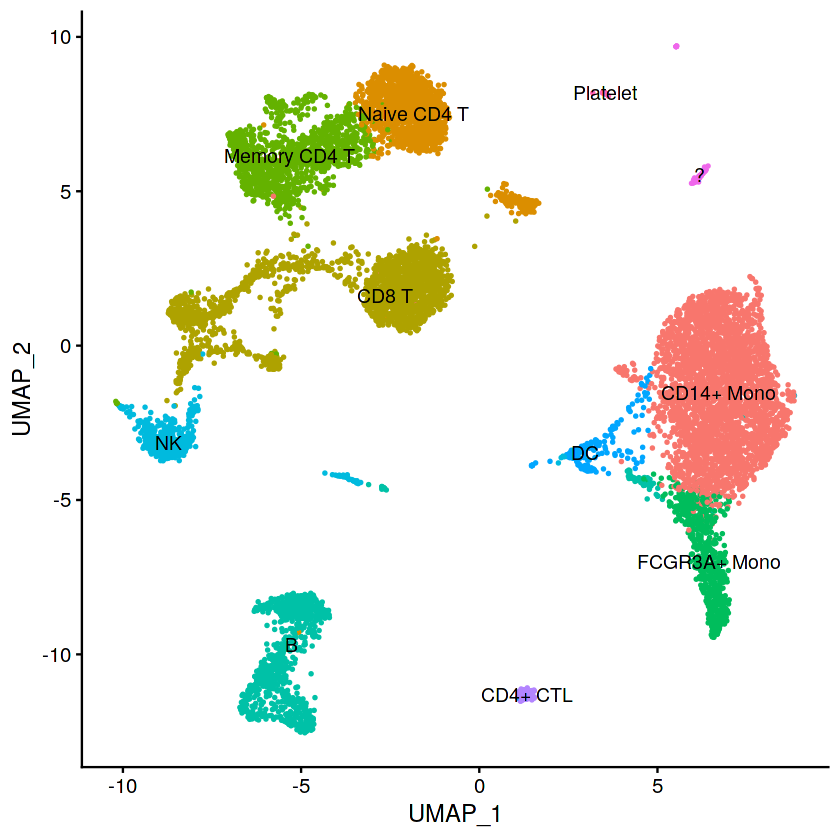

In [497]:
DimPlot(pbmc2, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

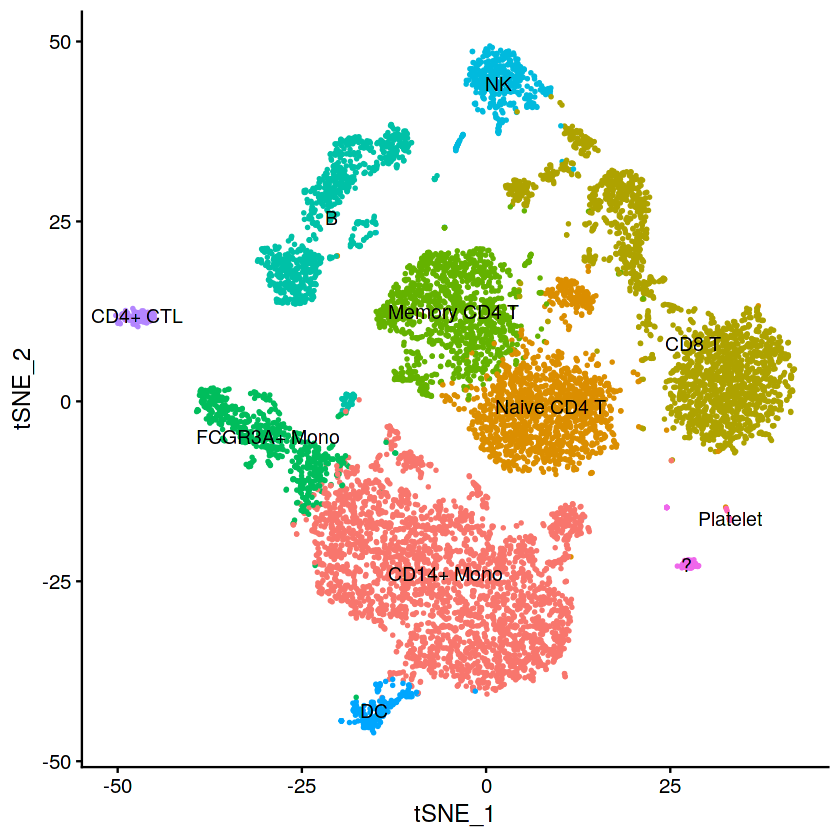

In [498]:
DimPlot(pbmc2, reduction = "tsne", label = TRUE, pt.size = 0.5) + NoLegend()

In [499]:
pdf(paste0(outputRoot, "11_assign_cell_type_plot.pdf"), width=5, height=5)
DimPlot(pbmc, reduction = "tsne", label = TRUE, pt.size = 0.5) + NoLegend()
DimPlot(pbmc2, reduction = "tsne", label = TRUE, pt.size = 0.5) + NoLegend()
DimPlot(pbmc2, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()
DimPlot(pbmc2, reduction = "pca", label = TRUE, pt.size = 0.5) + NoLegend()
dev.off()

png 
  2

### （todo）SingleR鉴定细胞类型

In [351]:
# 安装包失败
if(0){
    library(SingleR)
    refdata <- HumanPrimaryCellAtlasData() #
    testdata <- GetAssayData(scRNA, slot="data")
    clusters <- scRNA@meta.data$seurat_clusters
    cellpred <- SingleR(test = testdata, ref = refdata, labels = refdata$label.main, 
                         method = "cluster", clusters = clusters, 
                         assay.type.test = "logcounts", assay.type.ref = "logcounts")
    celltype = data.frame(ClusterID=rownames(cellpred), celltype=cellpred$labels, stringsAsFactors = F)
    write.csv(celltype,"cell_identify/celltype_singleR.csv",row.names = F)
    scRNA@meta.data$celltype = "NA"
    for(i in 1:nrow(celltype)){
        scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]
    }
}

### 添加新meta.data字段

In [500]:
head(cellTypes)
levels(cellTypes$cellType)

cluster cellType     one           
1 0       CD14+ Mono   0-CD14+ Mono  
2 1       Naive CD4 T  1-Naive CD4 T 
3 2       CD8 T        2-CD8 T       
4 3       Memory CD4 T 3-Memory CD4 T
5 4       CD8 T        4-CD8 T       
6 5       FCGR3A+ Mono 5-FCGR3A+ Mono

[1] "?"            "B"            "CD14+ Mono"   "CD4+ CTL"     "CD8 T"       
 [6] "DC"           "FCGR3A+ Mono" "Memory CD4 T" "Naive CD4 T"  "NK"          
[11] "Platelet"

In [501]:
print(cellTypes$cluster)
head(pbmc2@meta.data$seurat_clusters)

 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19


[1] 0  13 0  7  0  9 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

In [502]:
# 添加一列新 meta.data
pbmc3=pbmc2
pbmc3@meta.data$cellType = "NA"

for(i in 1:nrow(cellTypes)){
    pbmc3@meta.data[which(pbmc3@meta.data$seurat_clusters == cellTypes$cluster[i]),'cellType'] <- as.character(cellTypes$cellType[i])
}
pbmc3@meta.data$cellType=as.factor(pbmc3@meta.data$cellType)

In [503]:
head( pbmc3@meta.data )

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters cellType  
AAACCCAGTATCGTAC 0               CD14+ Mono
AAACCCAGTCGGTGAA 13              CD8 T     
AAACCCAGTTAGAAAC 0               CD14+ Mono
AAACCCAGTTATCTTC 7               NK        
AAACCCAGTTGCCGAC 0               CD14+ Mono
AAACCCAGTTTCCCAC 9               CD14+ Mono

In [504]:
table(pbmc3@meta.data$cellType, pbmc3@meta.data$seurat_clusters)

              
                  0    1    2    3    4    5    6    7    8    9   10   11   12
  ?               0    0    0    0    0    0    0    0    0    0    0    0    0
  B               0    0    0    0    0    0  542    0  389    0    0    0    0
  CD14+ Mono   2807    0    0    0    0    0    0    0    0  232    0    0    0
  CD4+ CTL        0    0    0    0    0    0    0    0    0    0    0    0  113
  CD8 T           0    0 1252    0  744    0    0    0    0    0    0    0    0
  DC              0    0    0    0    0    0    0    0    0    0  188    0    0
  FCGR3A+ Mono    0    0    0    0    0  654    0    0    0    0    0    0    0
  Memory CD4 T    0    0    0 1242    0    0    0    0    0    0    0    0    0
  Naive CD4 T     0 1322    0    0    0    0    0    0    0    0    0  170    0
  NK              0    0    0    0    0    0    0  437    0    0    0    0    0
  Platelet        0    0    0    0    0    0    0    0    0    0    0    0    0
              
          

### 每个类型抽样100个细胞，怎么做到？

#### 探究 cluster 14 和谁更像

In [505]:
colnames(pbmc@assays$RNA@counts)[1:10]

[1] "AAACCCAGTATCGTAC" "AAACCCAGTCGGTGAA" "AAACCCAGTTAGAAAC" "AAACCCAGTTATCTTC"
 [5] "AAACCCAGTTGCCGAC" "AAACCCAGTTTCCCAC" "AAACCCATCAGACAAA" "AAACCCATCCATACTT"
 [9] "AAACCCATCCATTCGC" "AAACGAACAACTCGAT"

In [506]:
levels(pbmc3)

[1] "CD14+ Mono"   "Naive CD4 T"  "CD8 T"        "Memory CD4 T" "FCGR3A+ Mono"
 [6] "B"            "NK"           "DC"           "CD4+ CTL"     "?"           
[11] "Platelet"

In [507]:
table(pbmc3@meta.data$cellType)


           ?            B   CD14+ Mono     CD4+ CTL        CD8 T           DC 
          73         1000         3082          113         2105          188 
FCGR3A+ Mono Memory CD4 T  Naive CD4 T           NK     Platelet 
         654         1242         1492          469           23 

In [508]:
pbmc3

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [509]:
head(pbmc3@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt RNA_snn_res.0.5
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0              
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 13             
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0              
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 7              
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0              
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 9              
                 seurat_clusters cellType  
AAACCCAGTATCGTAC 0               CD14+ Mono
AAACCCAGTCGGTGAA 13              CD8 T     
AAACCCAGTTAGAAAC 0               CD14+ Mono
AAACCCAGTTATCTTC 7               NK        
AAACCCAGTTGCCGAC 0               CD14+ Mono
AAACCCAGTTTCCCAC 9               CD14+ Mono

In [510]:
subset(pbmc3, cellType == "CD14+ Mono" )

An object of class Seurat 
22860 features across 3082 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

In [456]:
head(pbmc3@active.ident)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
      CD14+ Mono     Memory CD4 T       CD14+ Mono               NK 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
      CD14+ Mono       CD14+ Mono 
11 Levels: CD14+ Mono Naive CD4 T CD8 T Memory CD4 T FCGR3A+ Mono B NK ... Platelet

#### 取子集 subset

In [515]:
# 从每个亚类中抽样: 
#bug: Seurat 的 subset不能用于函数内部 https://github.com/satijalab/seurat/issues/4058
downSample=function(SeuratObj, n=100){
    #SeuratObj=pbmc3;   n=100
    set.seed(314649593)
    sampled.cells=c()
    for(item2 in levels(SeuratObj)){
        print( paste("item2 =", item2 ) )
        small_=subset(SeuratObj, cellType == item2) ## 为什么找不到这个参数呢？
        cids=colnames(small_@assays$RNA@counts)
        #
        cells.to.sample=ifelse(length(cids)>n, n, length(cids)) #不够100个的全要。超过100个的抽100个。
        cat( tp, "\t", length(cids),'\t', cells.to.sample, "\n")
        
        cid.tmp <- sample(x = cids, size = cells.to.sample, replace = F)
        sampled.cells=c(sampled.cells, cid.tmp)
    }
    
    # Create a vector of cells on which variable genes will be computed
    subset(SeuratObj, cells = sampled.cells)
}

# test
if(0){
    print("This may work if Do NOT put subset in a function.")
    pbmc.small=downSample(pbmc3, n=100)
    pbmc.small
}

In [511]:
pbmc.small=subset(pbmc3, downsample=100)
pbmc.small

An object of class Seurat 
22860 features across 996 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, umap, tsne

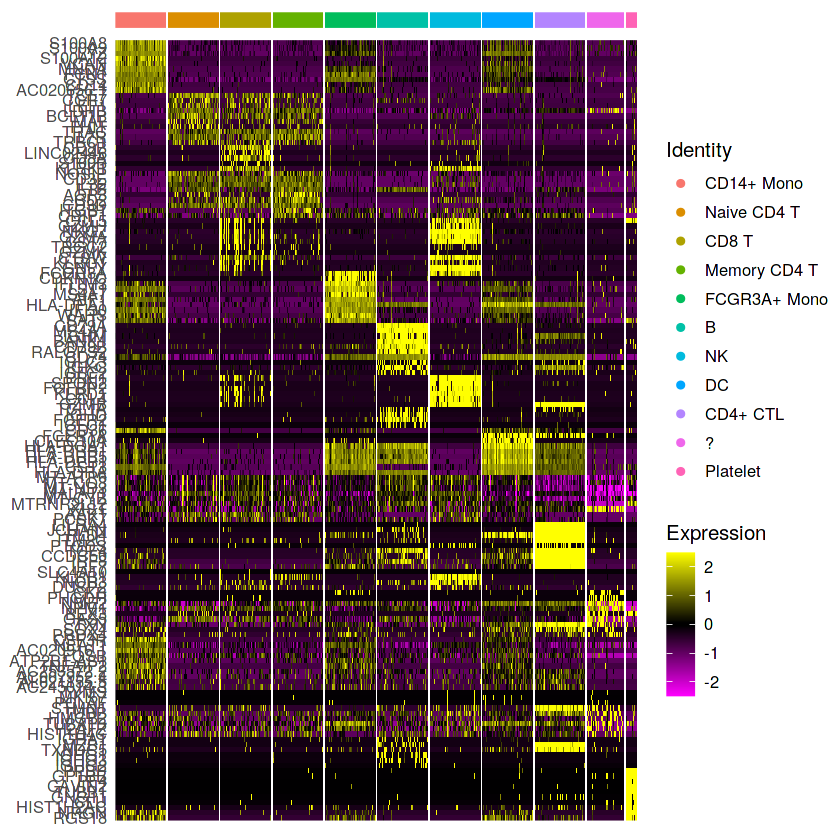

In [512]:
DoHeatmap(pbmc.small, features = top10$gene, label = F)+ theme(text = element_text(size = 12))

In [513]:
pdf( paste0(outputRoot, "11-small-set.heatmap.pdf"), width=8, height=12)
DoHeatmap(pbmc.small, features = top10$gene, label = F)+ theme(text = element_text(size = 8))
dev.off()

png 
  2

### save

In [517]:
saveRDS(pbmc3, file = file = paste0(outputRoot,"pbmc10k_final.rds") ) #long time: 2min